------ standard imports ------ #

# Robotics, Vision & Control 3e: for Python
## Chapter 15: Vision-Based Control

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(linewidth=120, formatter={'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})

In [2]:
np.random.seed(0)

In [3]:
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


------------------------------ #

# 15.1 Position-Based Visual Servoing


In [4]:
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -2));

In [5]:
P = mkgrid(2, 0.5)

In [8]:
p = camera.project_point(P, objpose=SE3.Tz(1))

In [9]:
P

array([[   -0.25,    -0.25,     0.25,     0.25],
       [   -0.25,     0.25,     0.25,    -0.25],
       [       0,        0,        0,        0]])

In [7]:
Te_C_G = camera.estpose(P, p, frame="camera");
Te_C_G.printline()

t = -1, -1, 3; rpy/zyx = 0°, 0°, 0°


In [13]:
Te_C_G.A

array([[       1,        0, -4.466e-09,       -1],
       [       0,        1, -4.466e-09,       -1],
       [4.466e-09, 4.466e-09,        1,        3],
       [       0,        0,        0,        1]])

In [8]:
T_Cd_G = SE3.Tz(1);

In [9]:
T_delta = Te_C_G * T_Cd_G.inv();
T_delta.printline()

t = -1, -1, 2; rpy/zyx = 0°, 0°, 0°


In [10]:
camera.pose = camera.pose * T_delta.interp1(0.05);

In [11]:
camera = CentralCamera.Default(pose = SE3.Trans(1, 1, -2));

In [12]:
T_Cd_G = SE3.Tz(1);

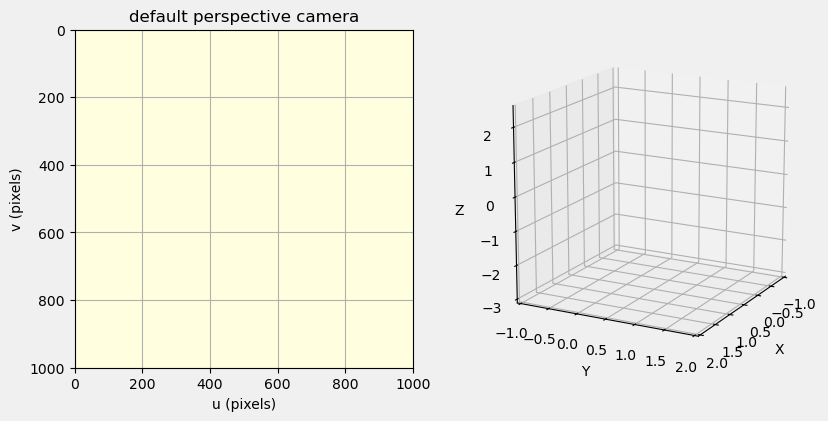

In [13]:
pbvs = PBVS(camera, P=P, pose_g=SE3.Trans(-1, -1, 2), pose_d=T_Cd_G, plotvol=[-1, 2, -1, 2, -3, 2.5])

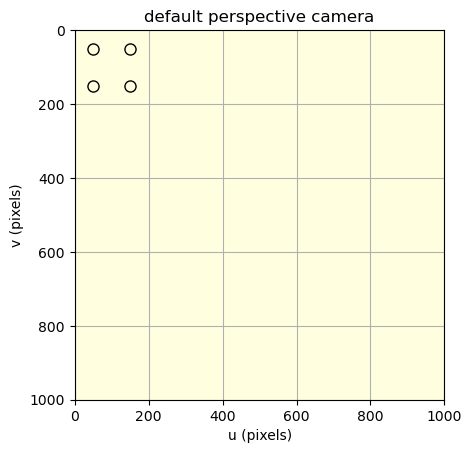

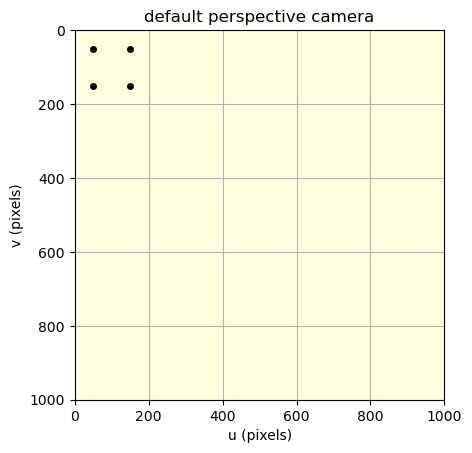

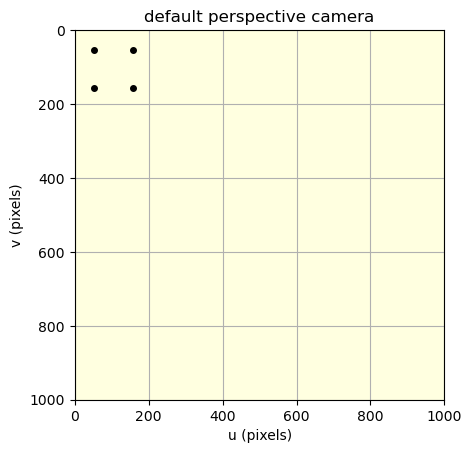

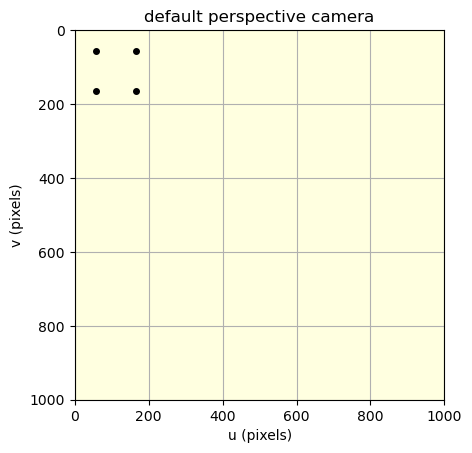

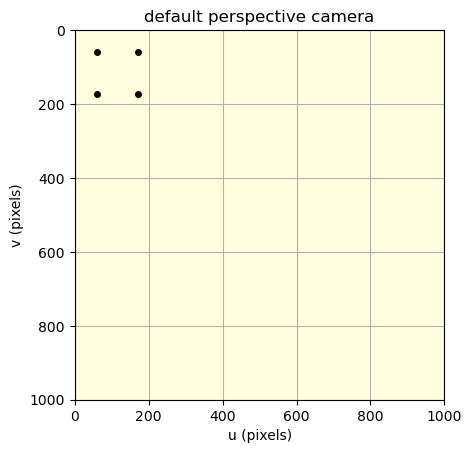

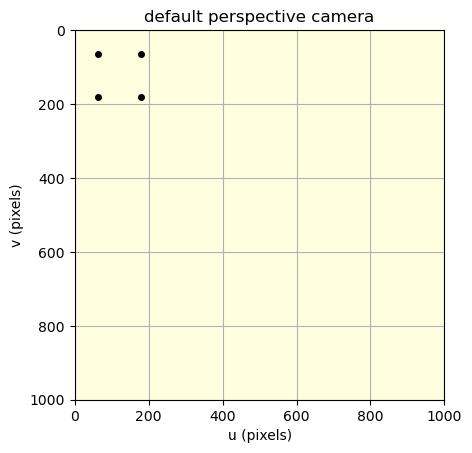

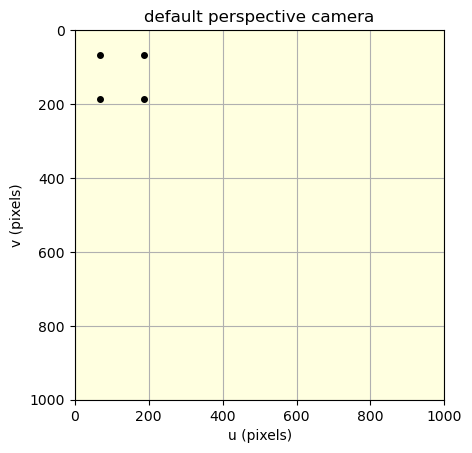

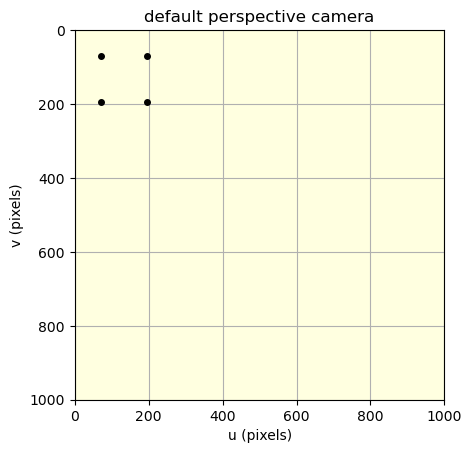

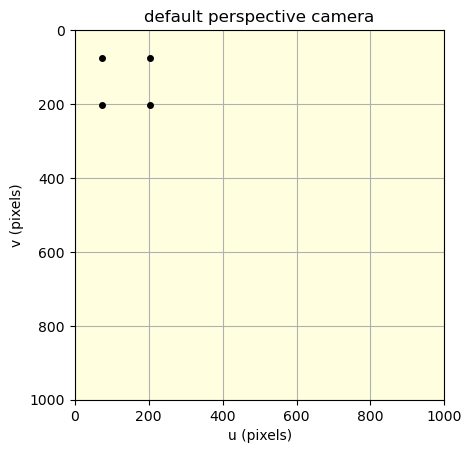

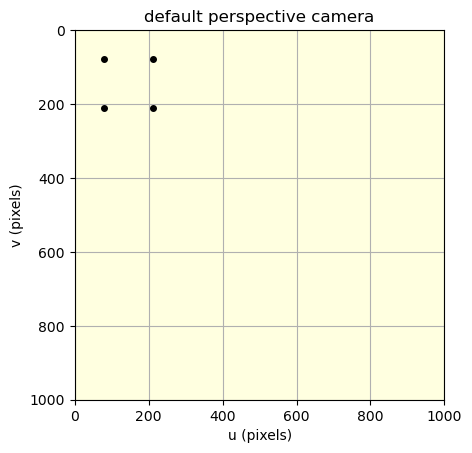

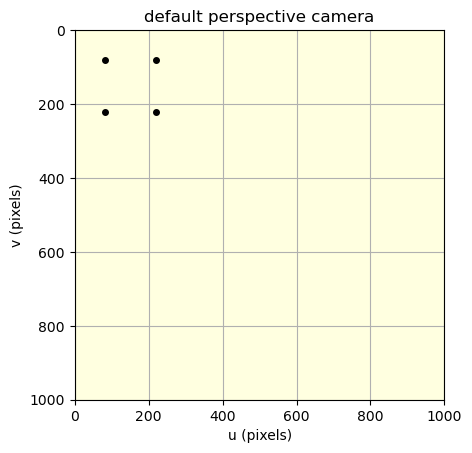

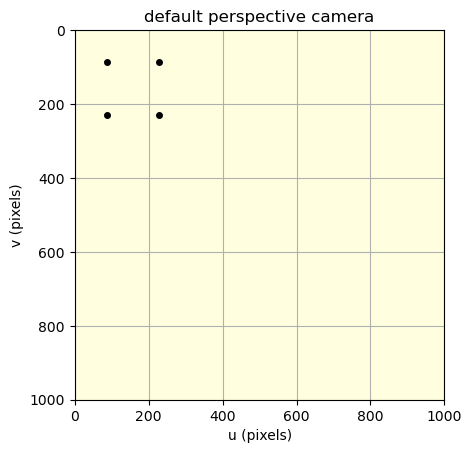

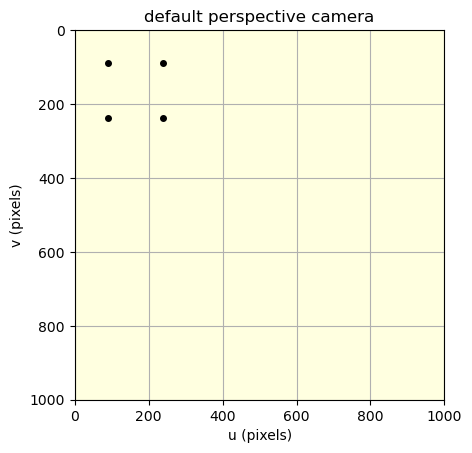

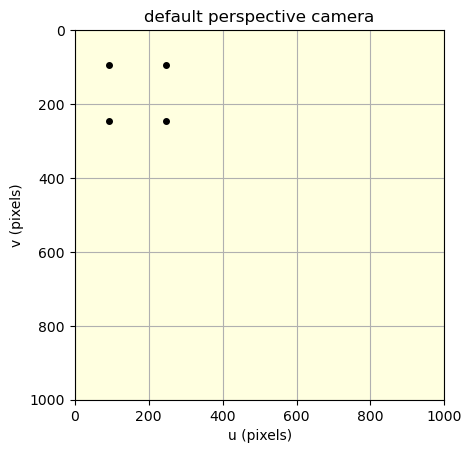

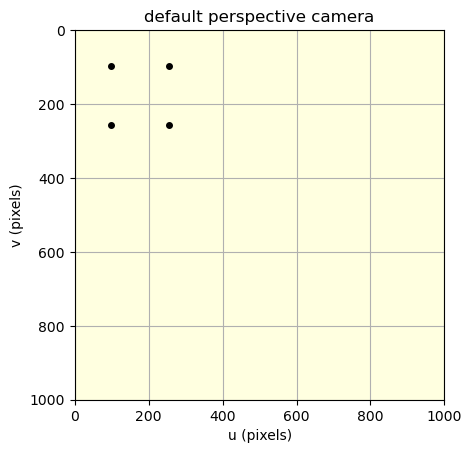

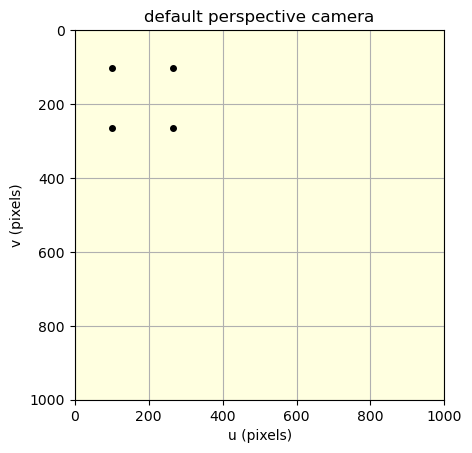

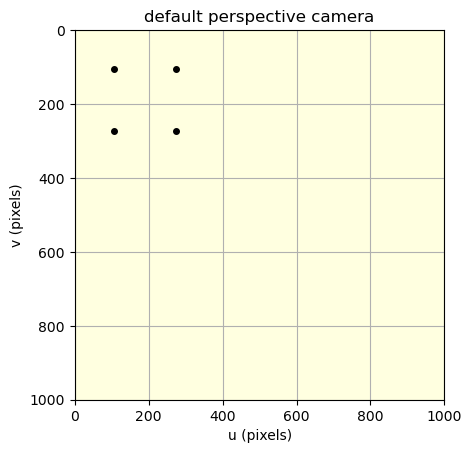

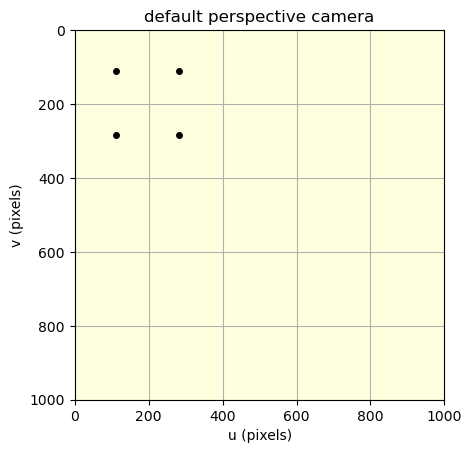

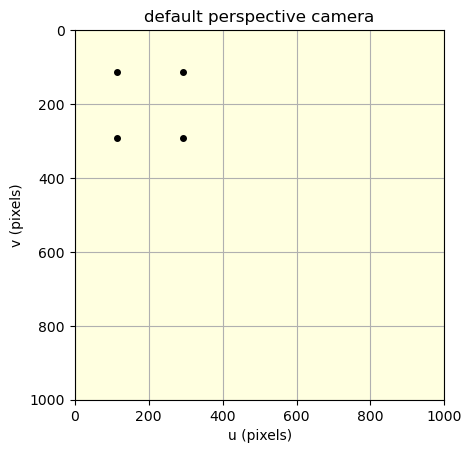

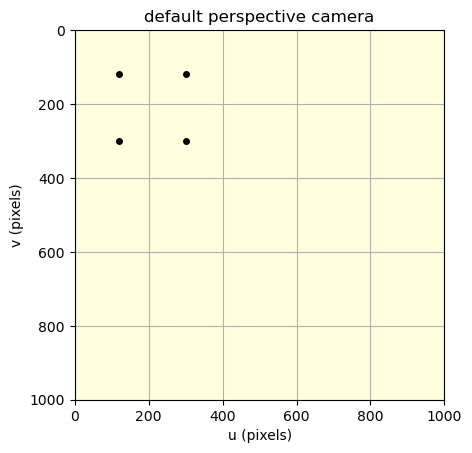

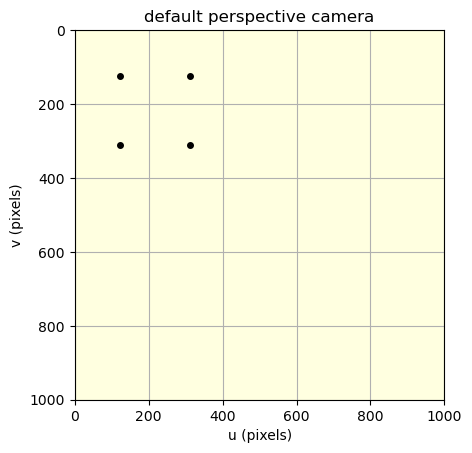

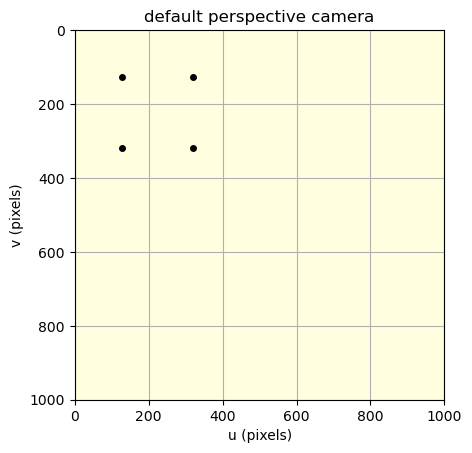

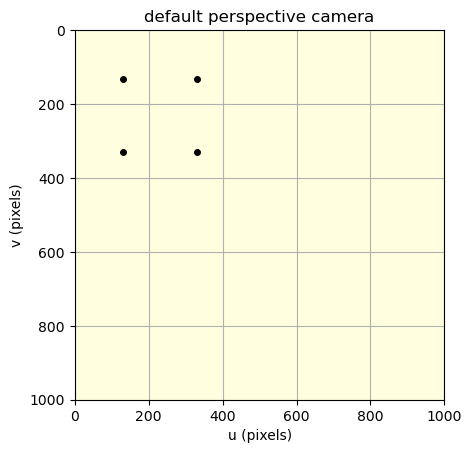

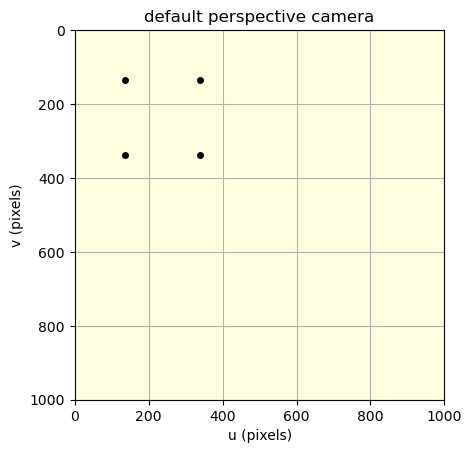

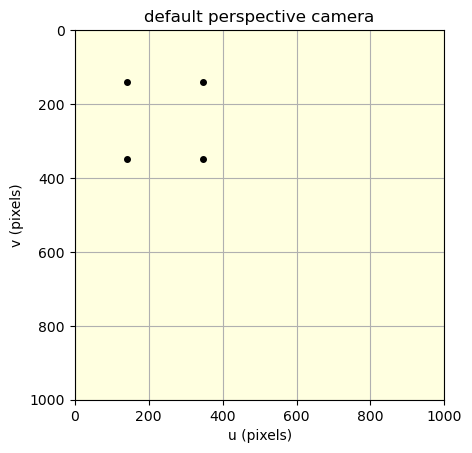

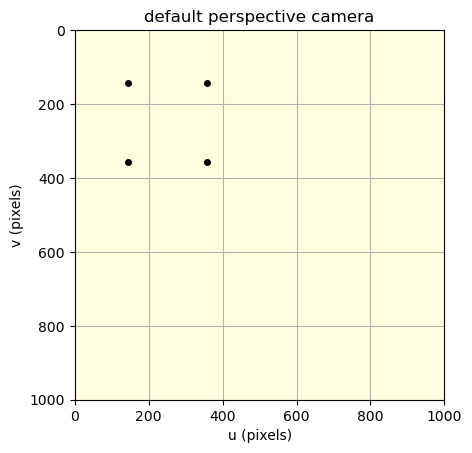

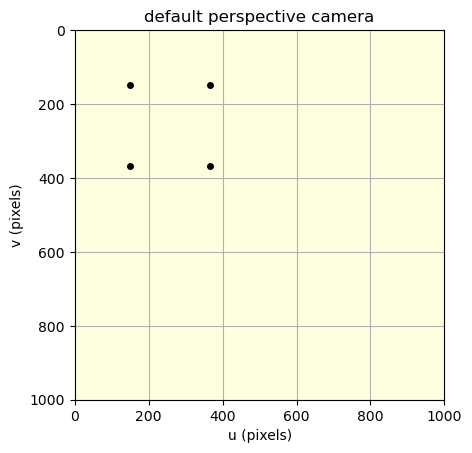

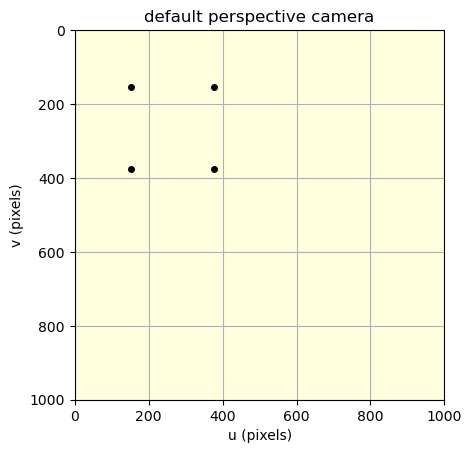

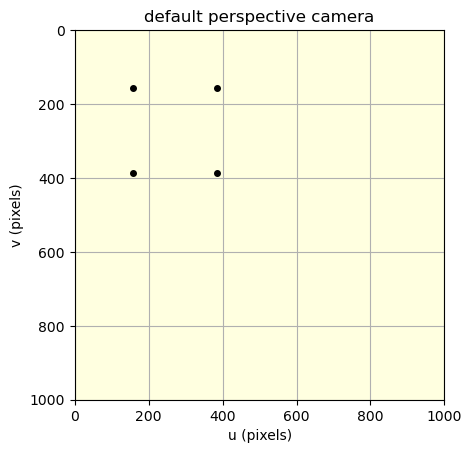

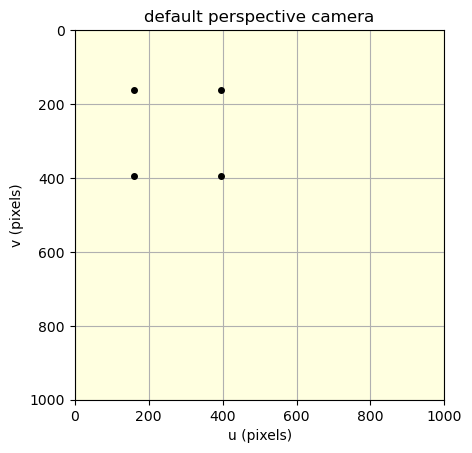

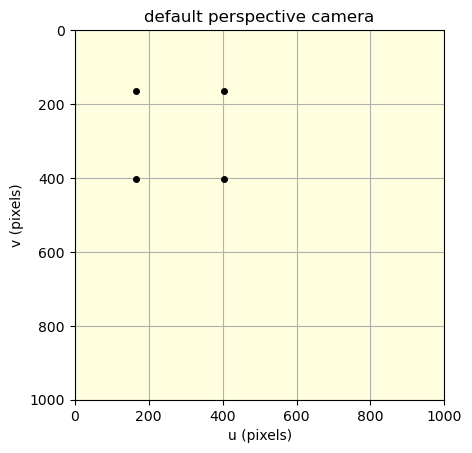

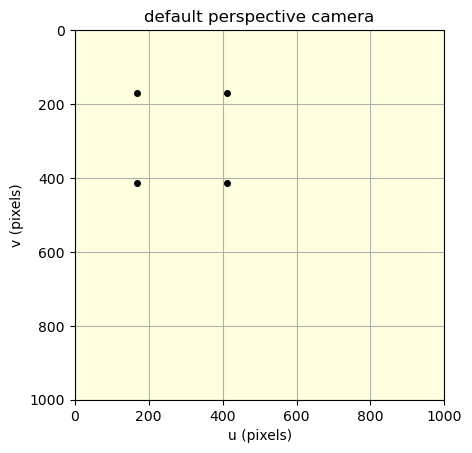

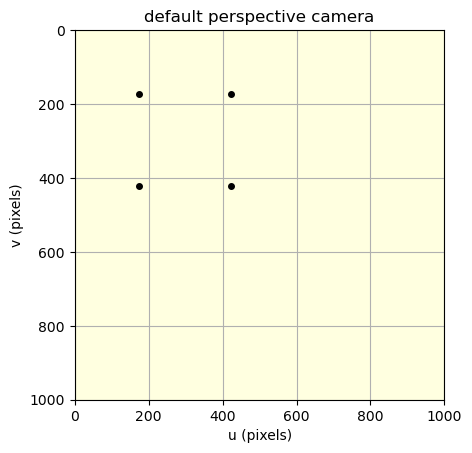

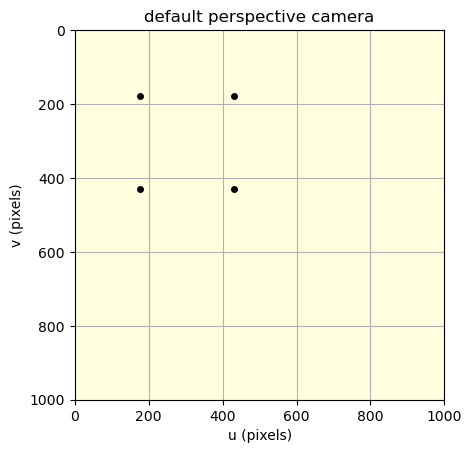

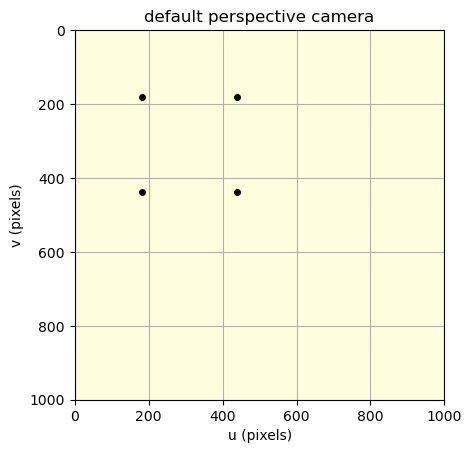

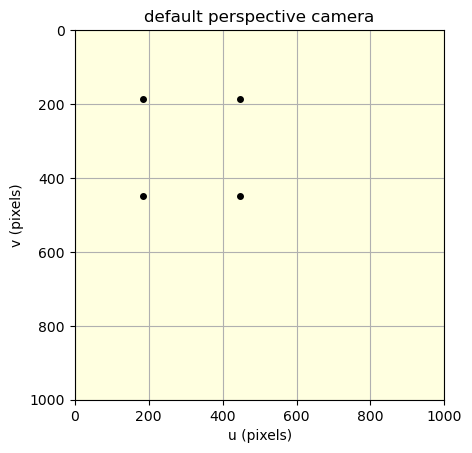

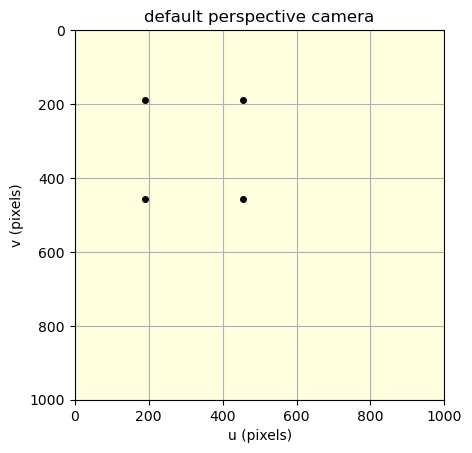

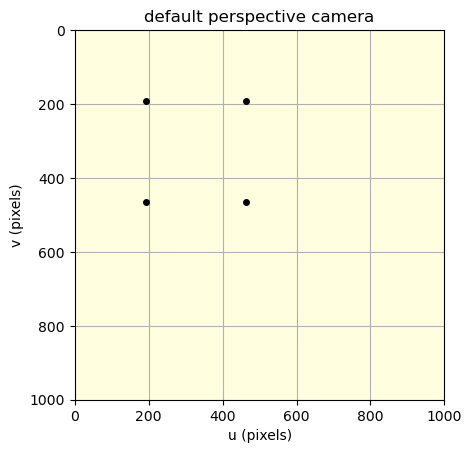

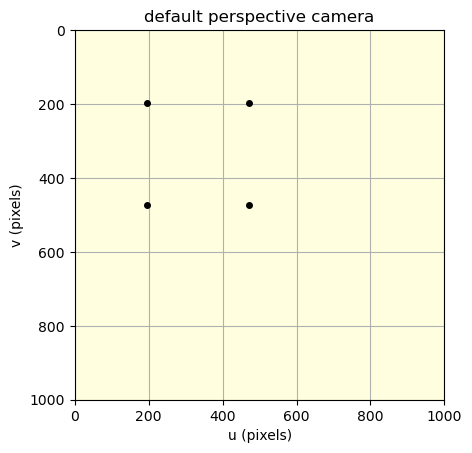

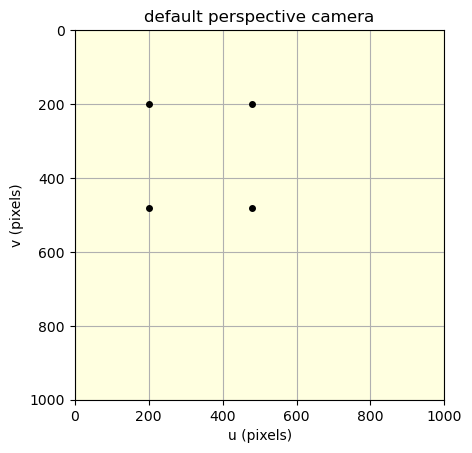

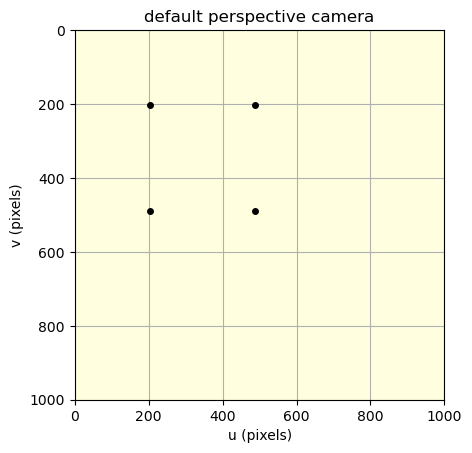

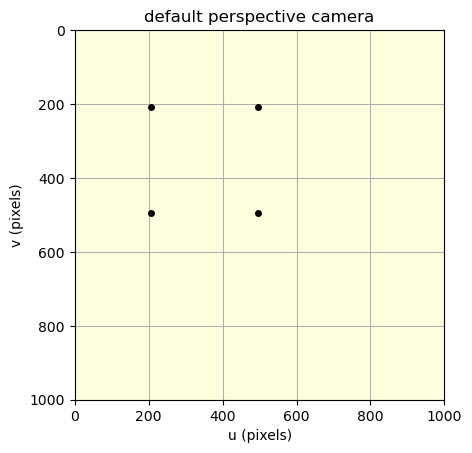

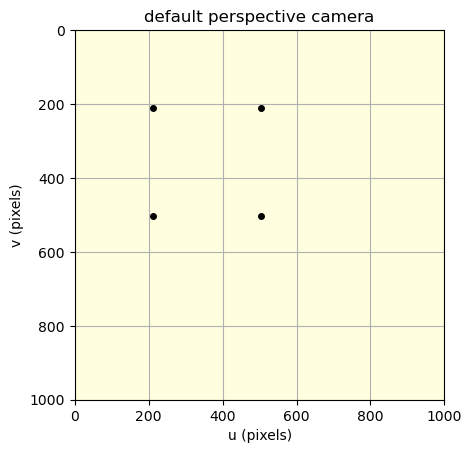

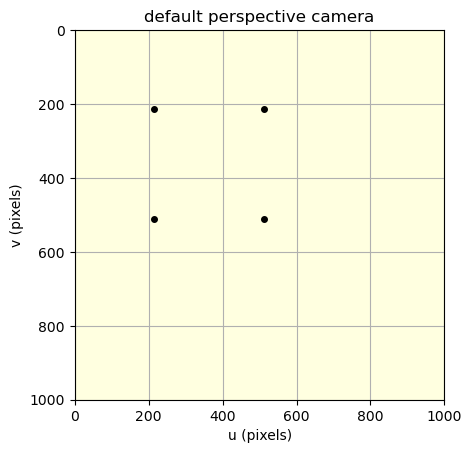

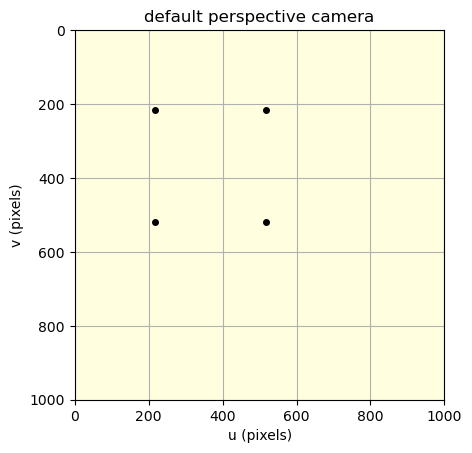

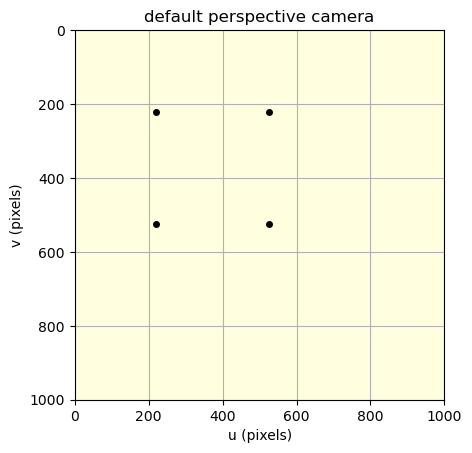

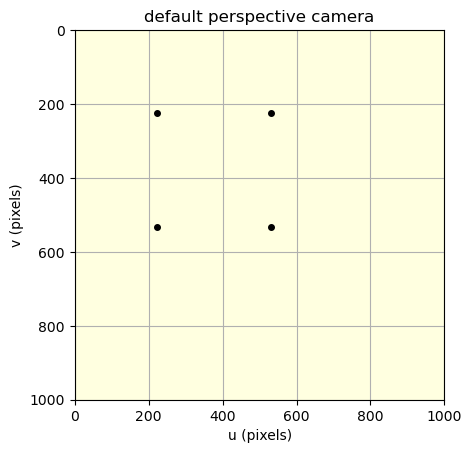

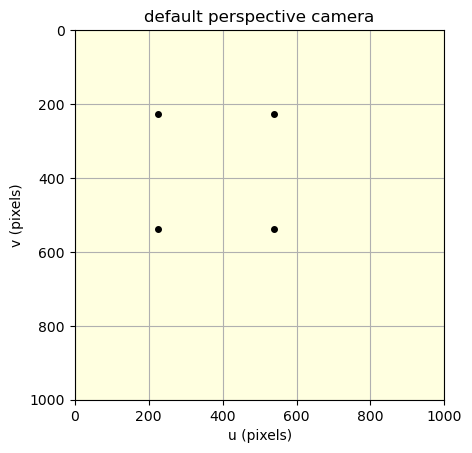

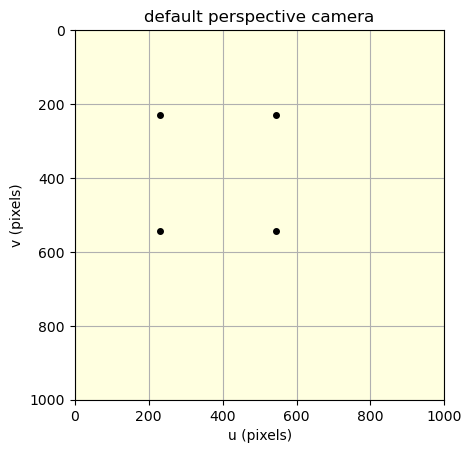

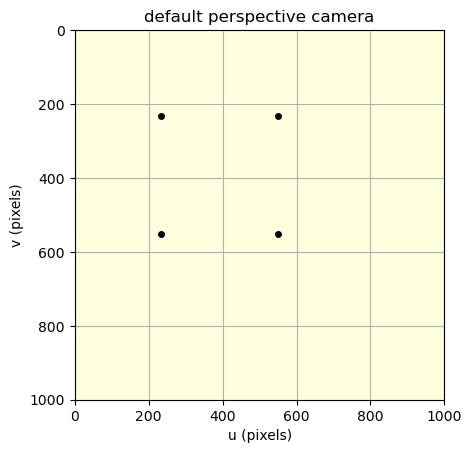

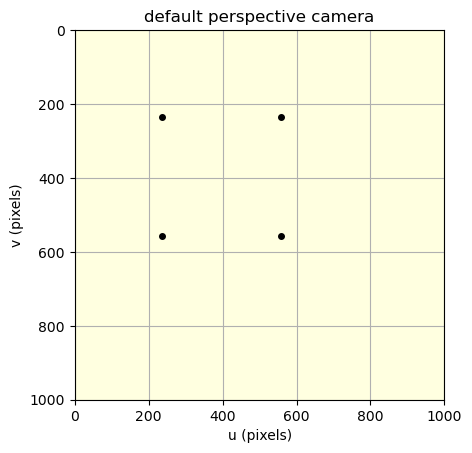

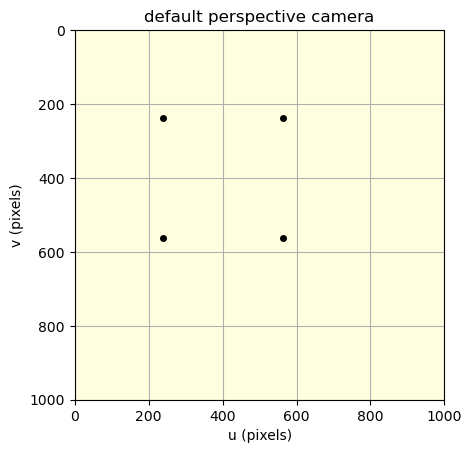

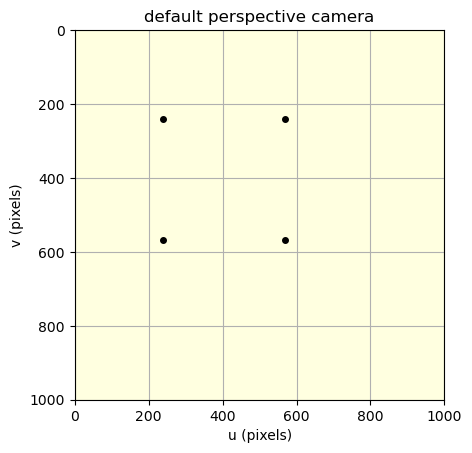

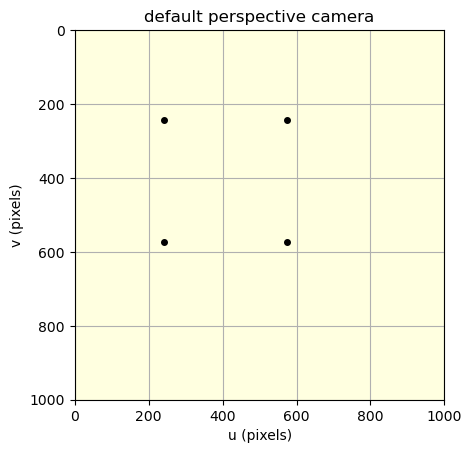

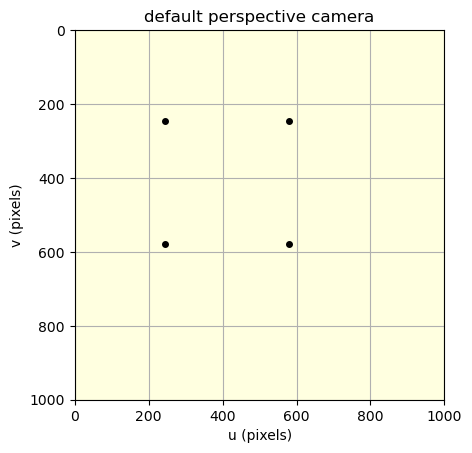

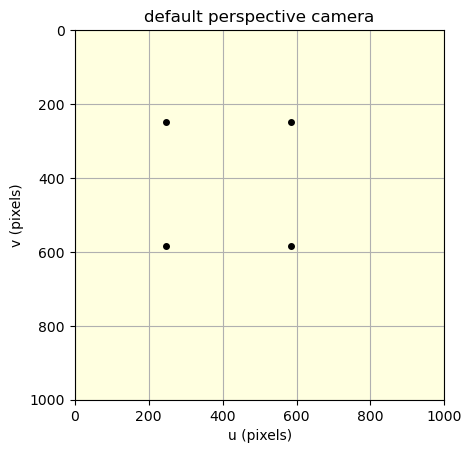

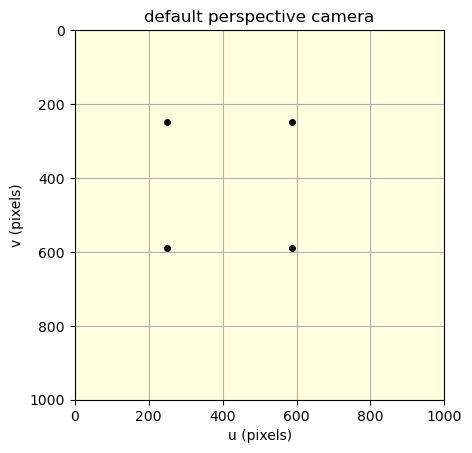

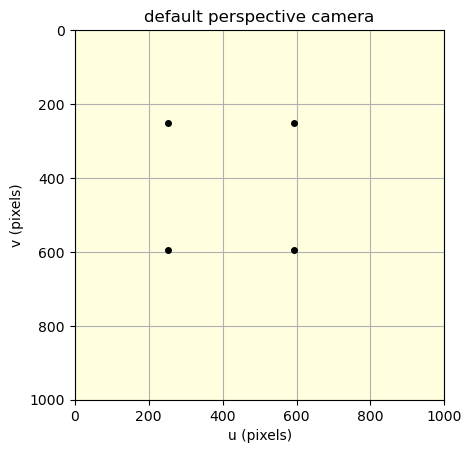

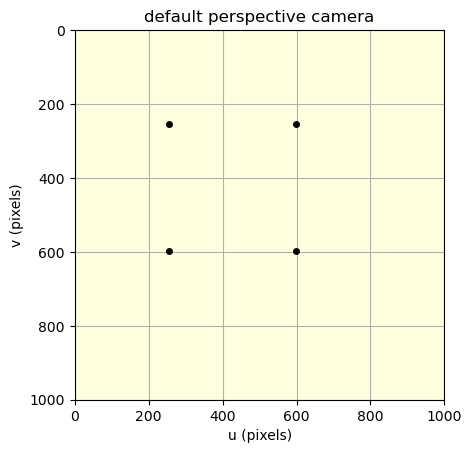

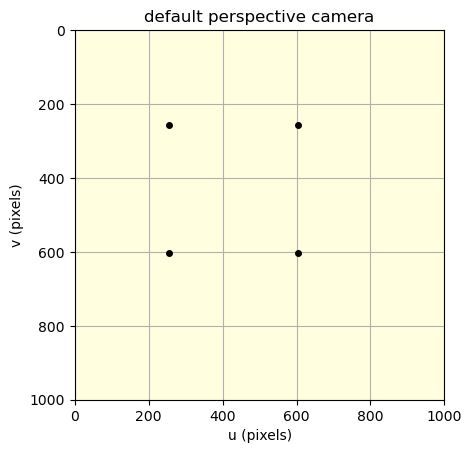

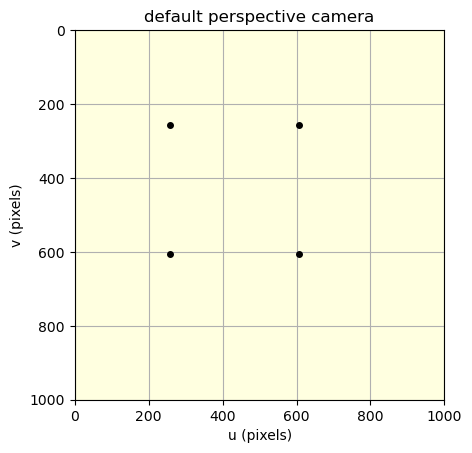

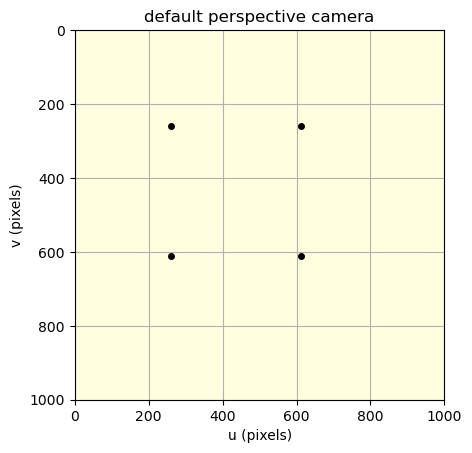

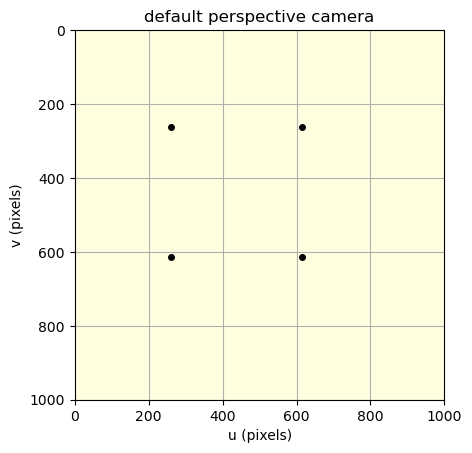

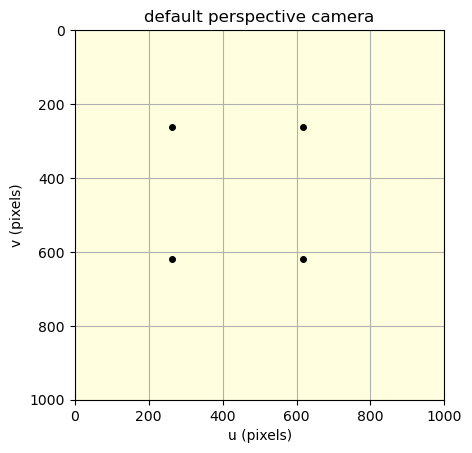

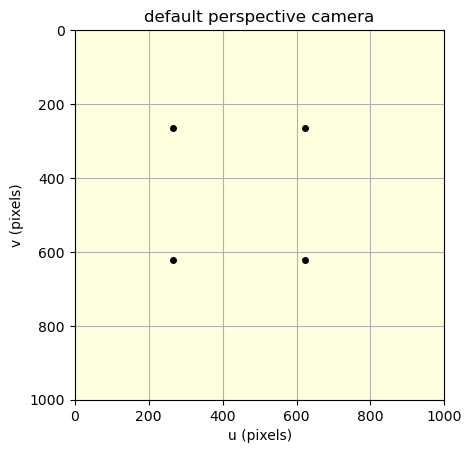

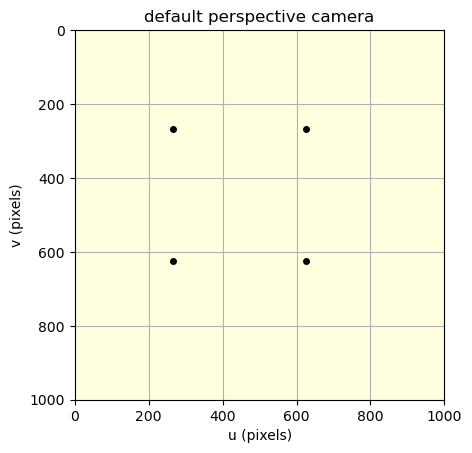

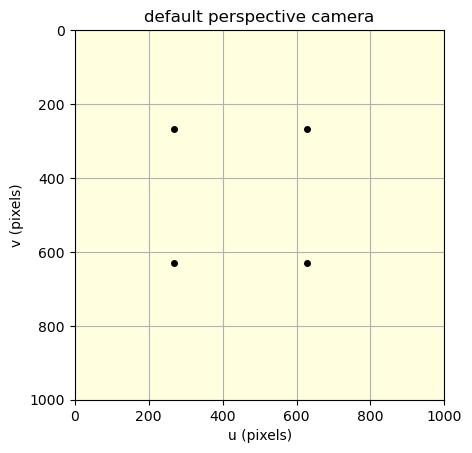

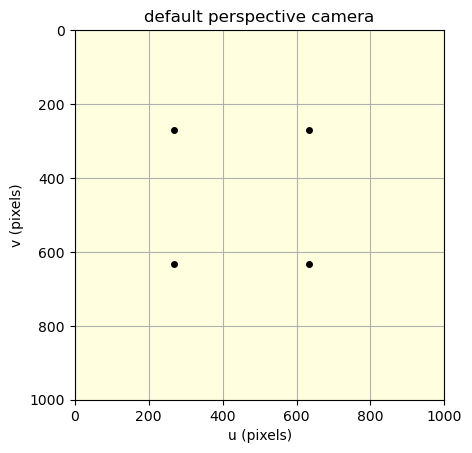

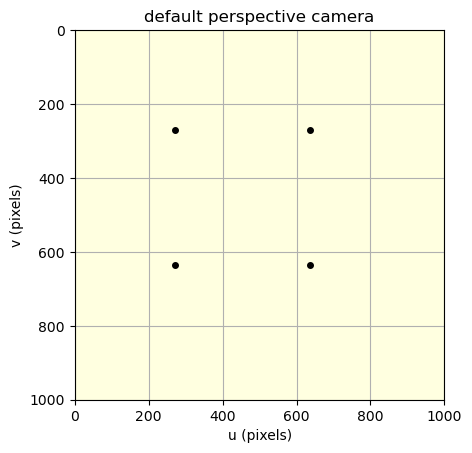

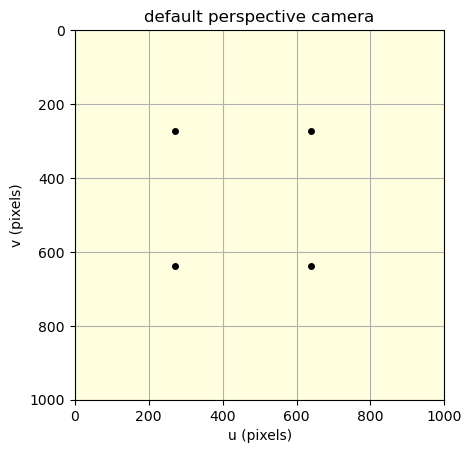

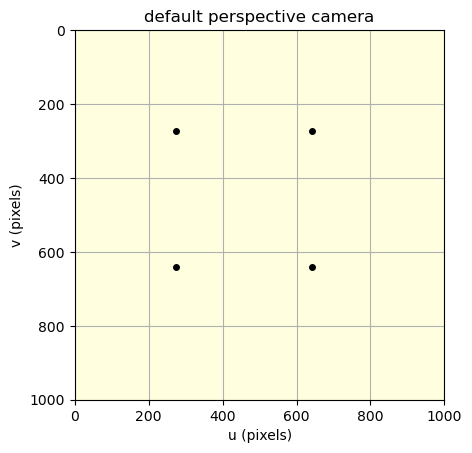

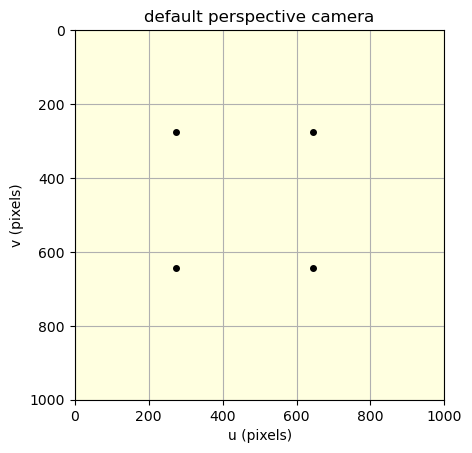

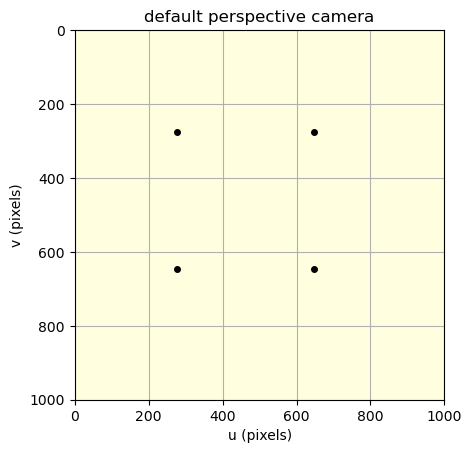

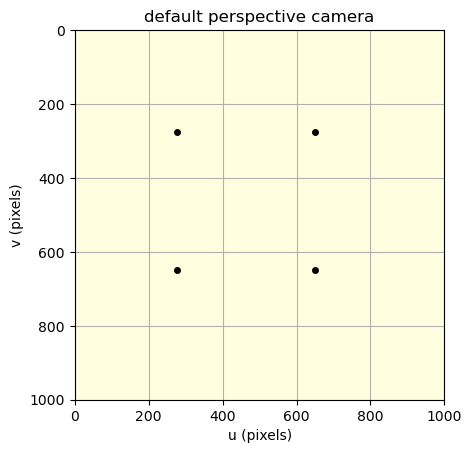

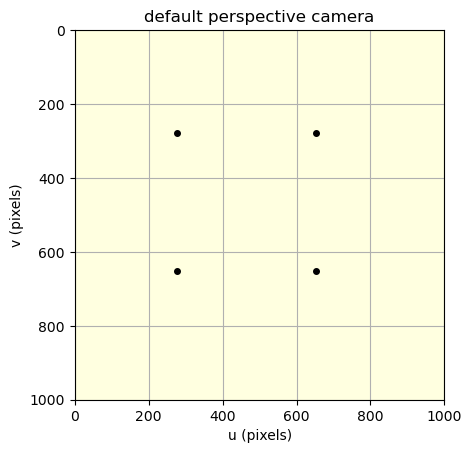

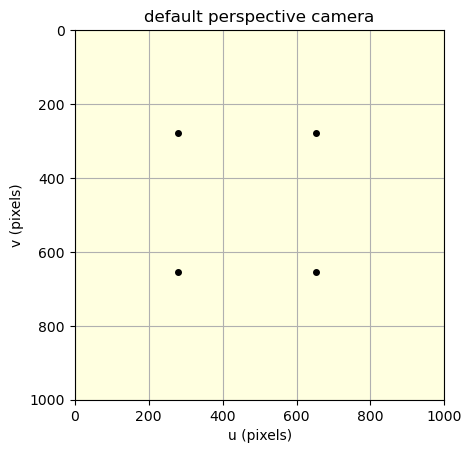

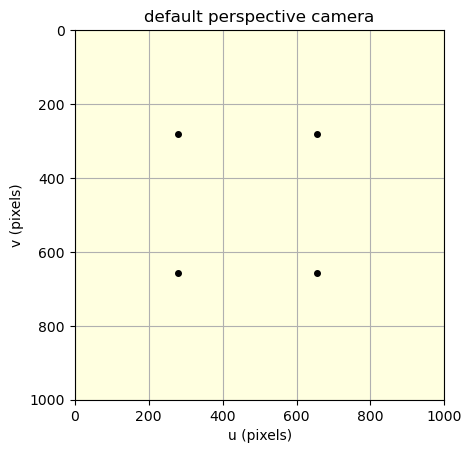

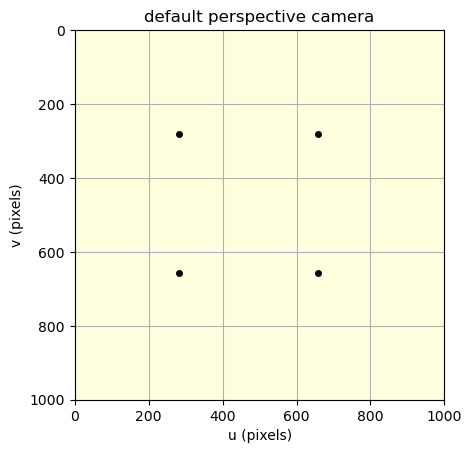

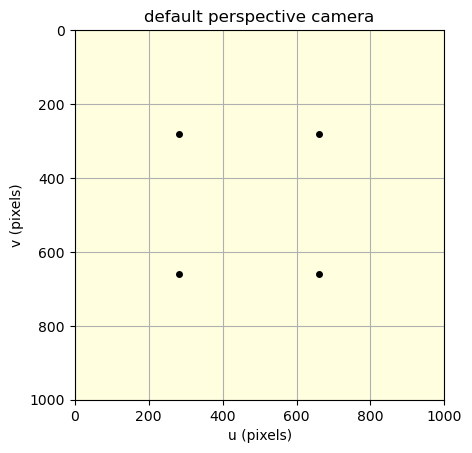

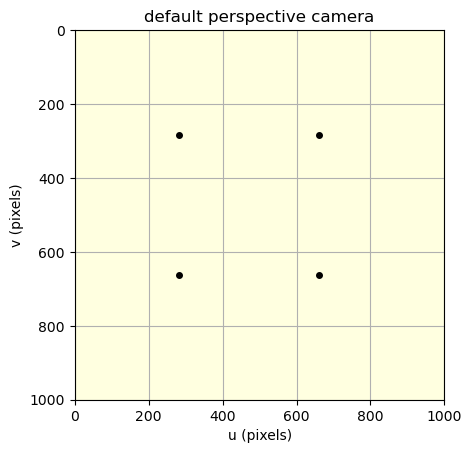

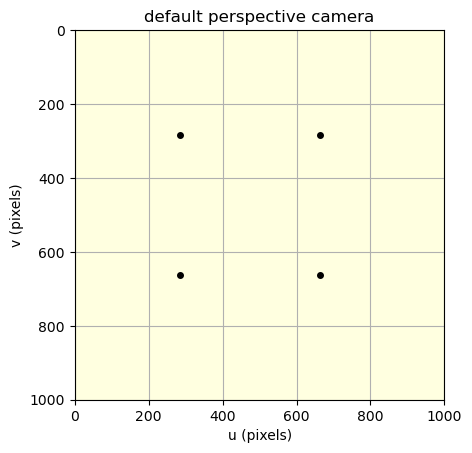

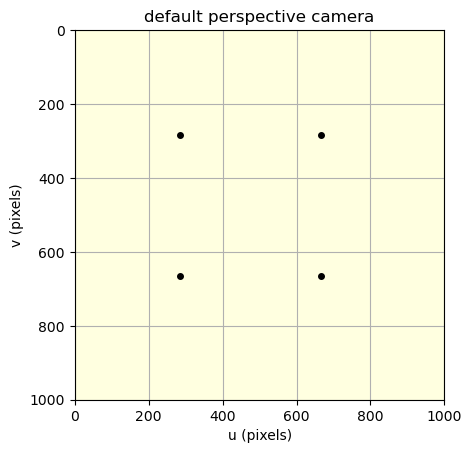

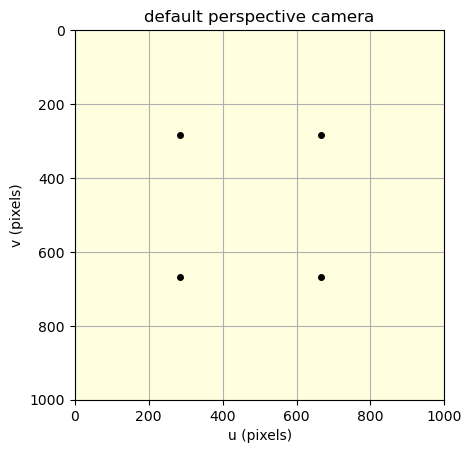

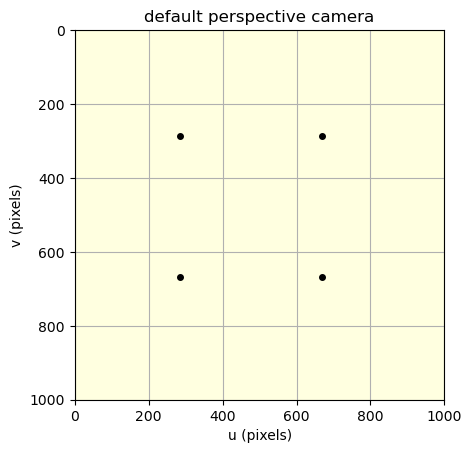

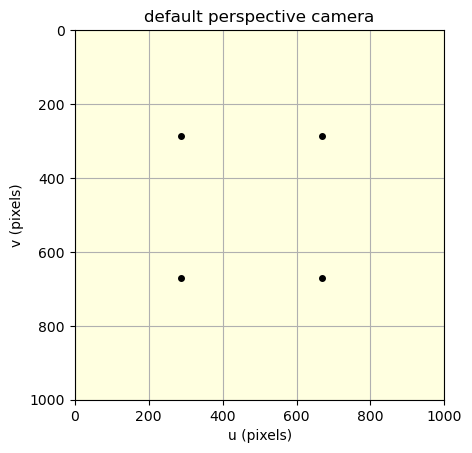

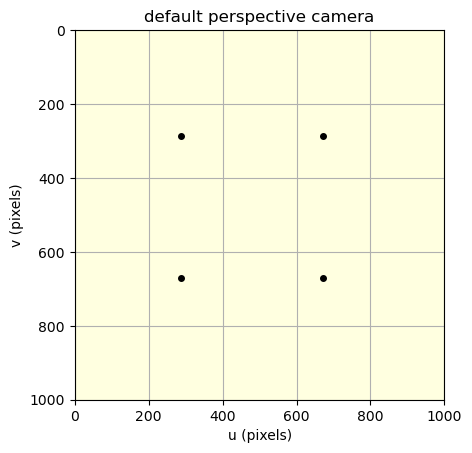

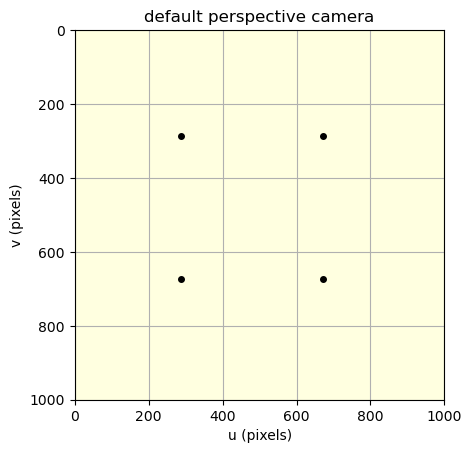

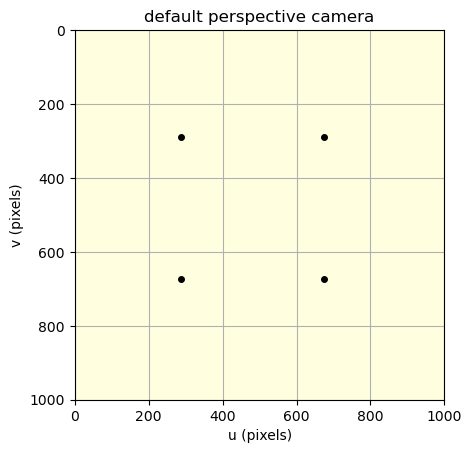

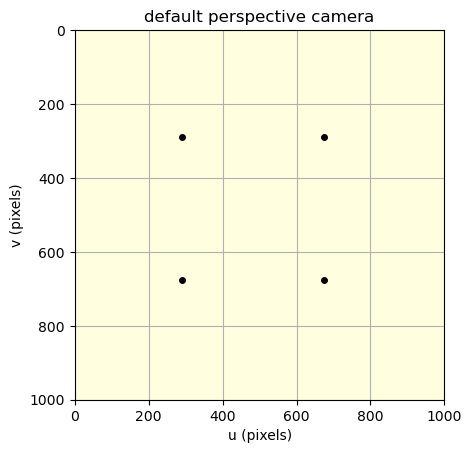

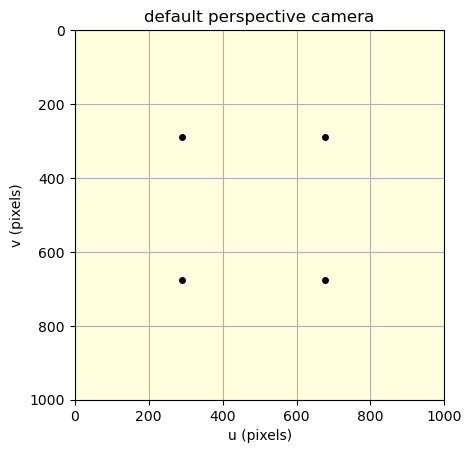

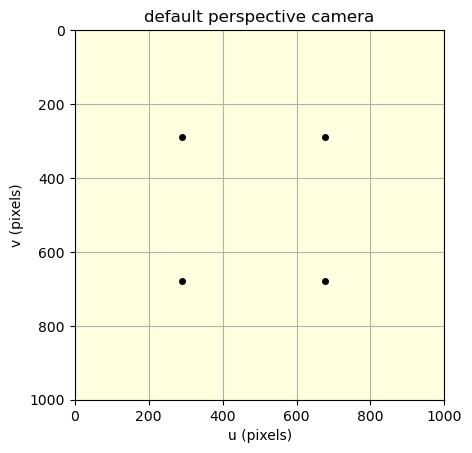

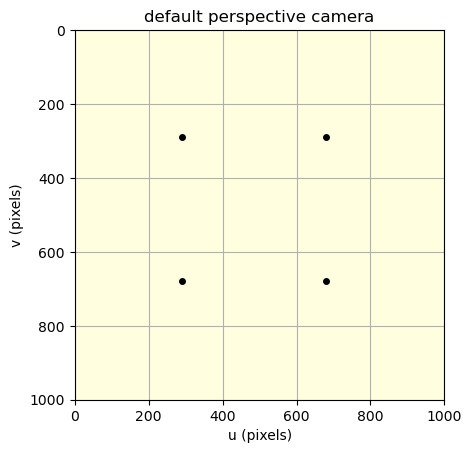

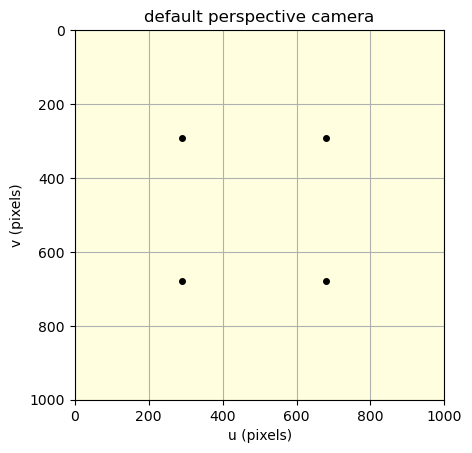

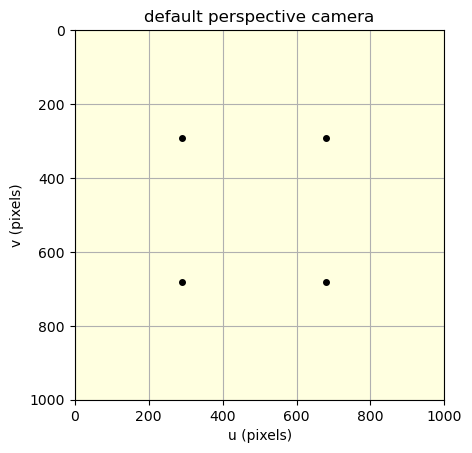

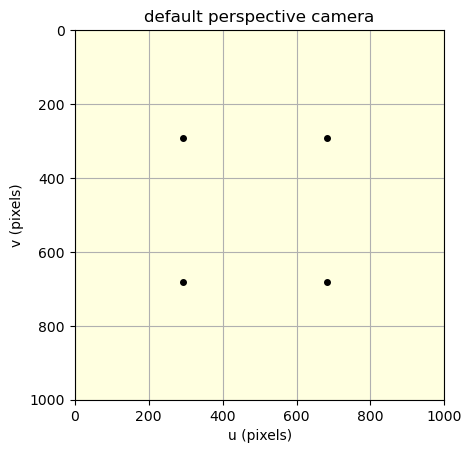

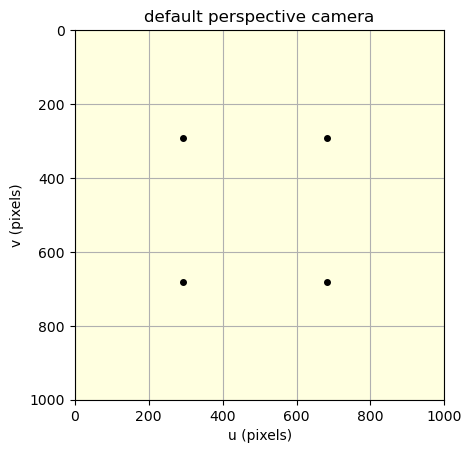

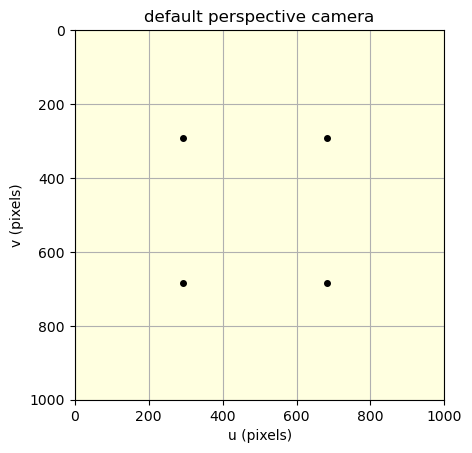

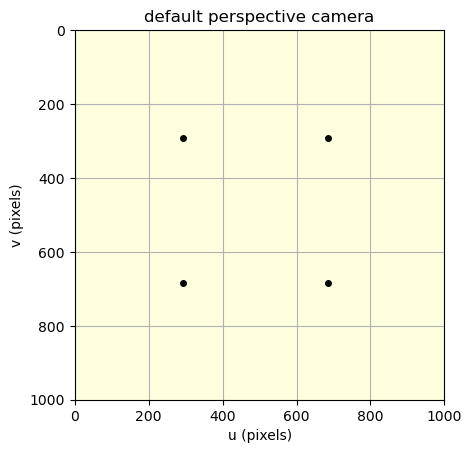

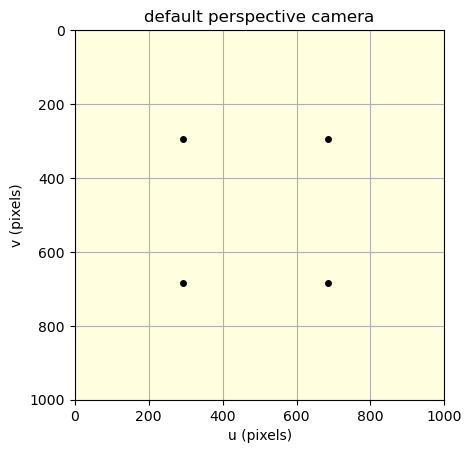

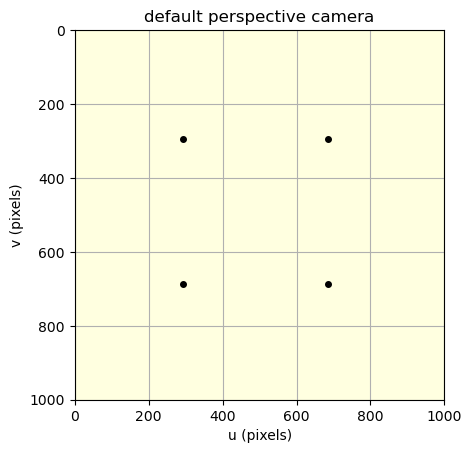

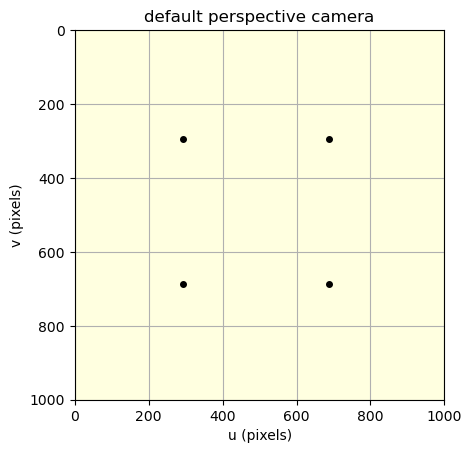

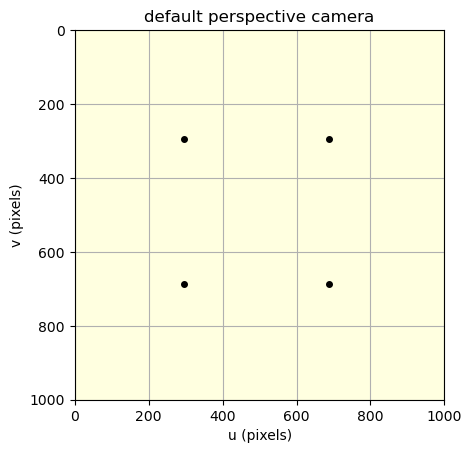

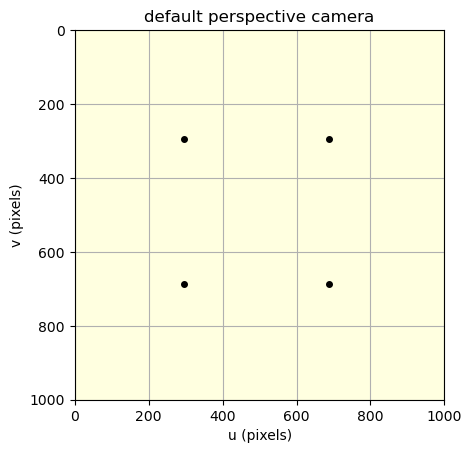

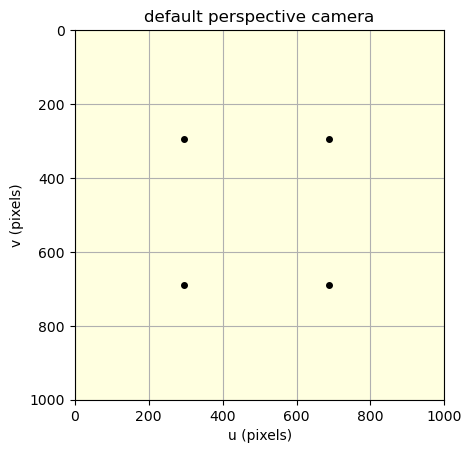

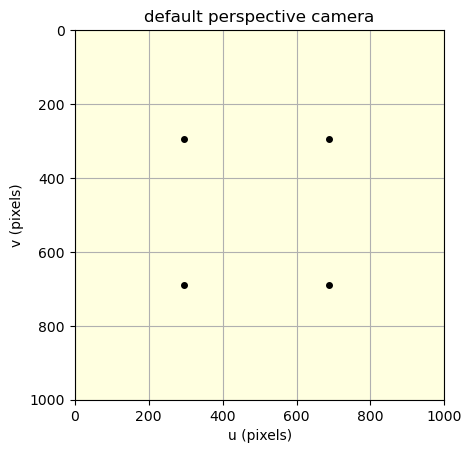

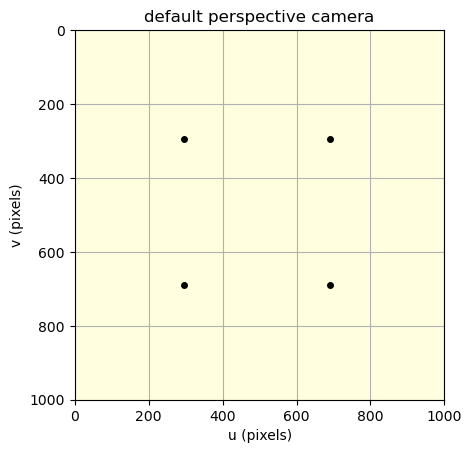

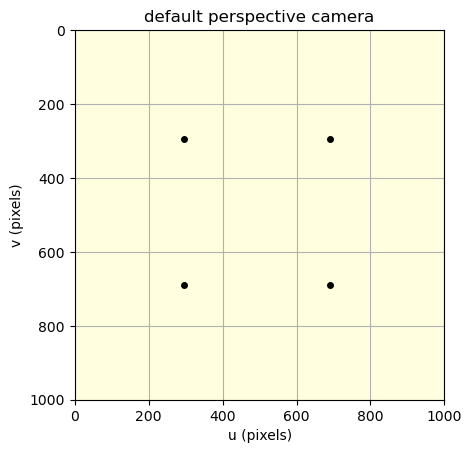

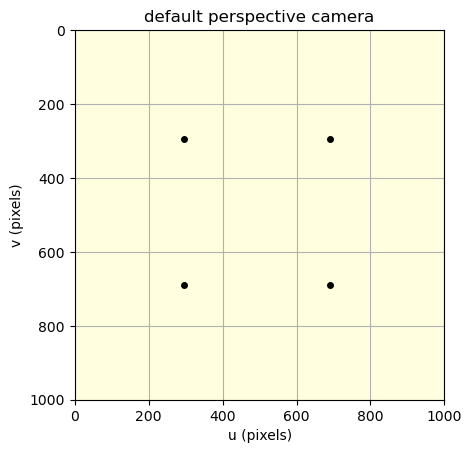

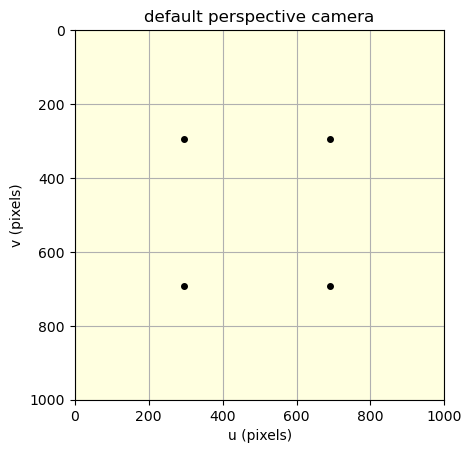

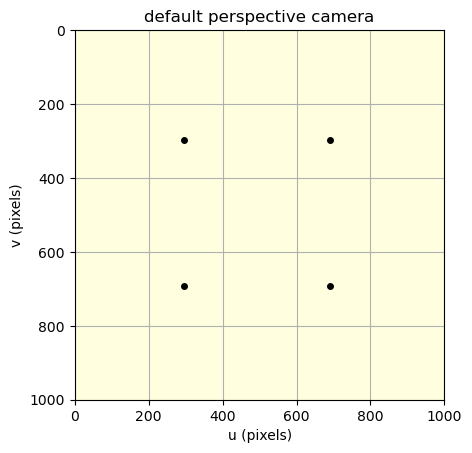

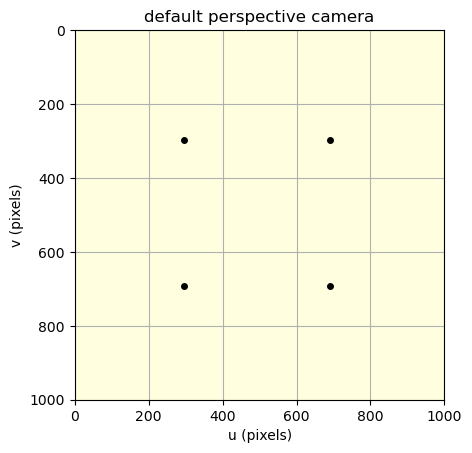

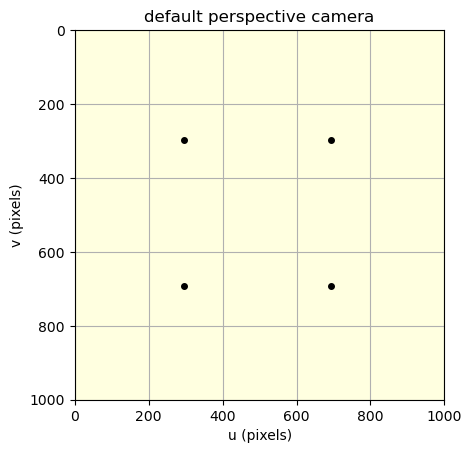

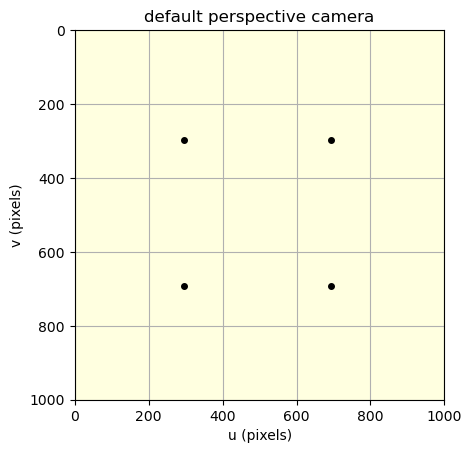

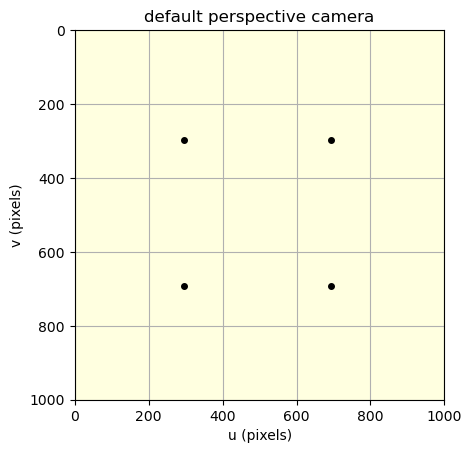

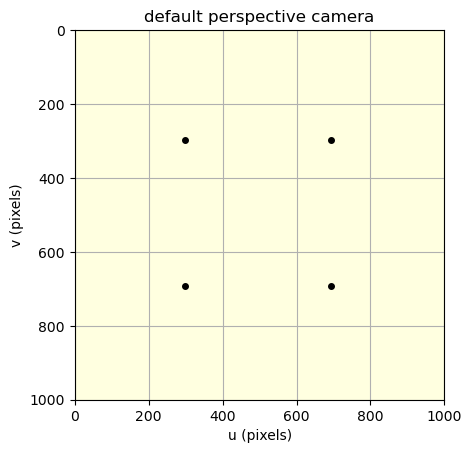

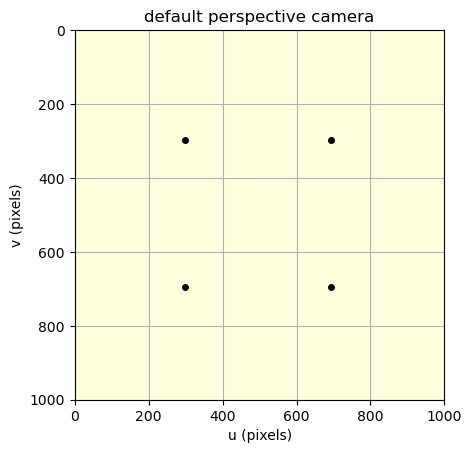

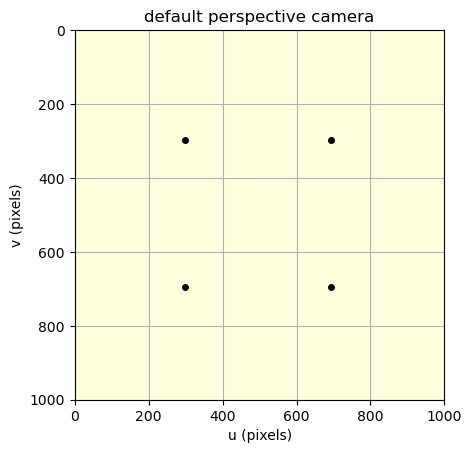

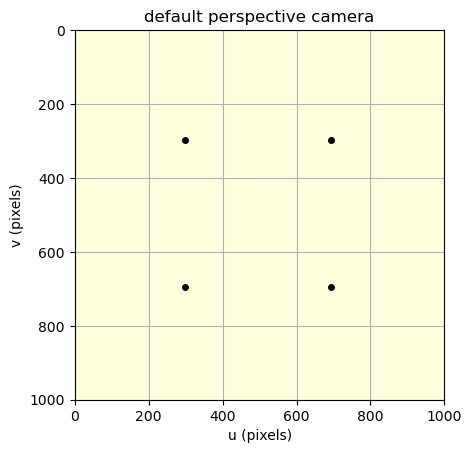

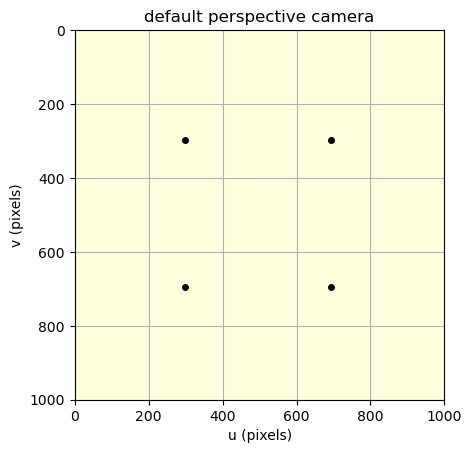

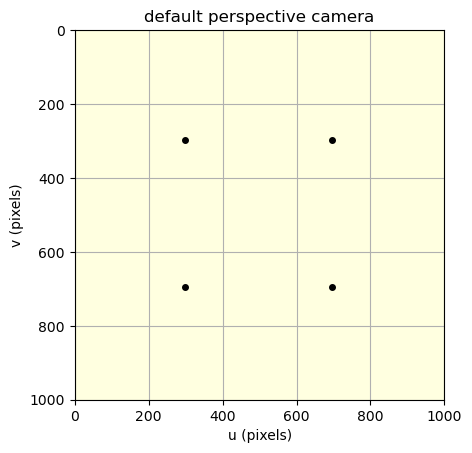

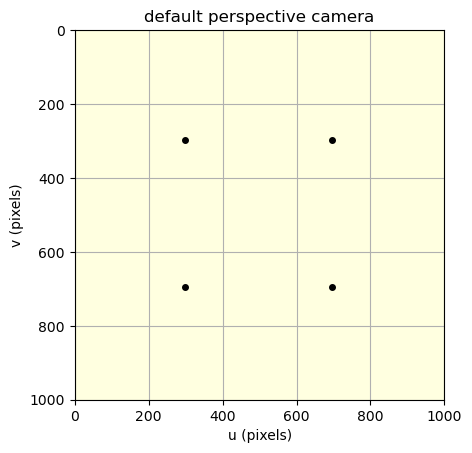

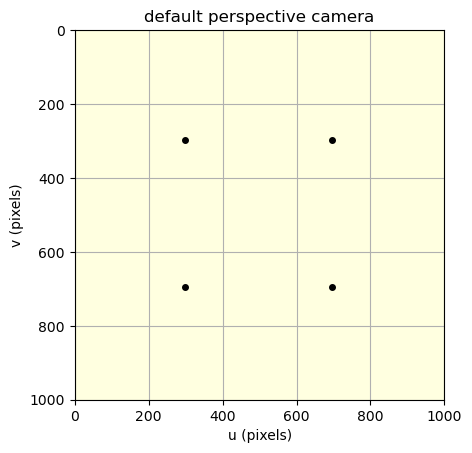

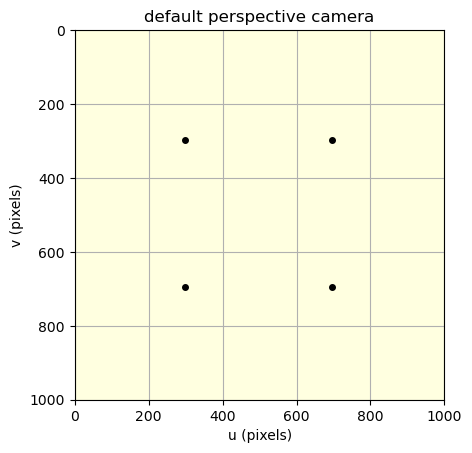

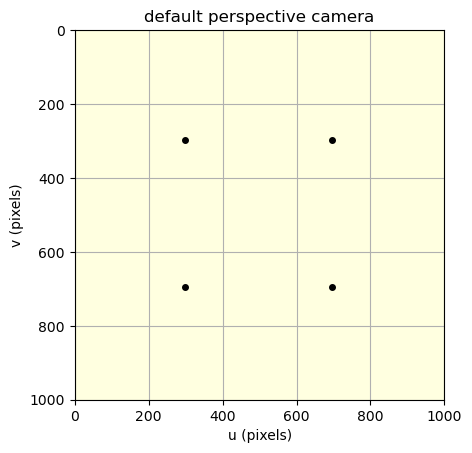

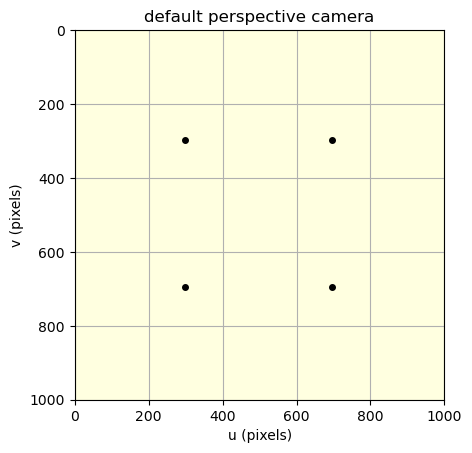

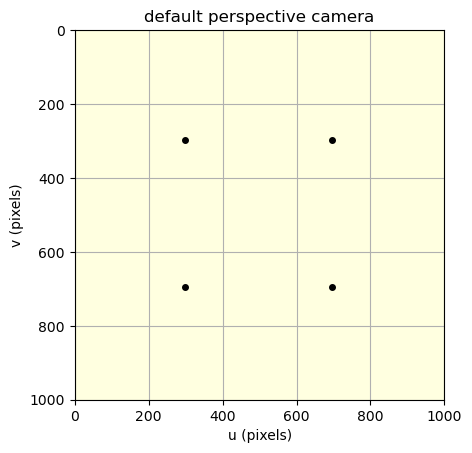

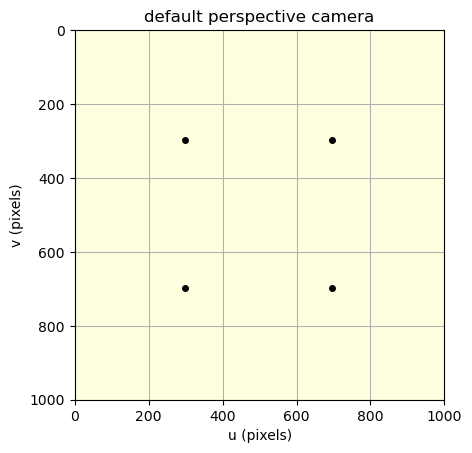

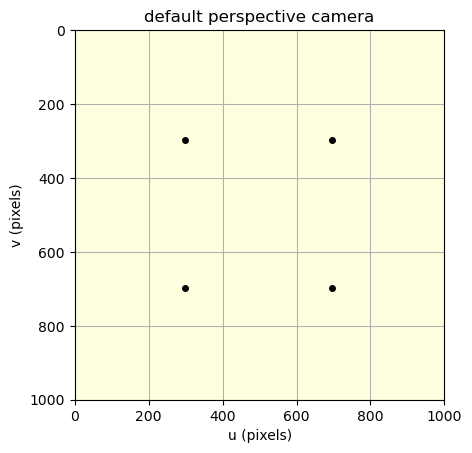

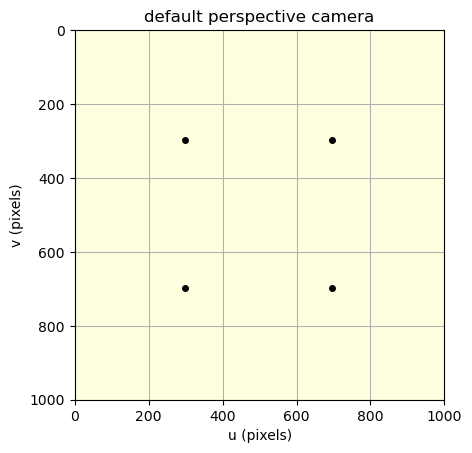

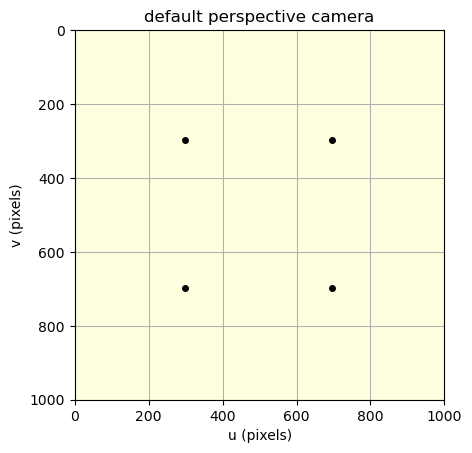

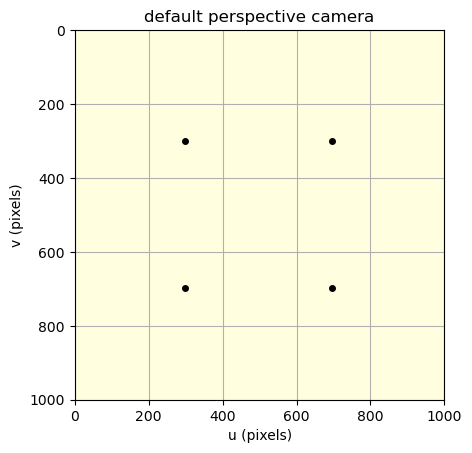

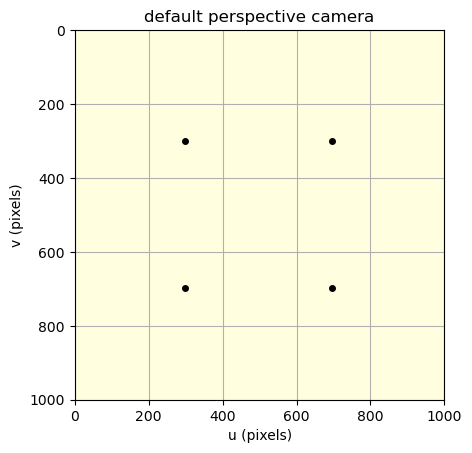

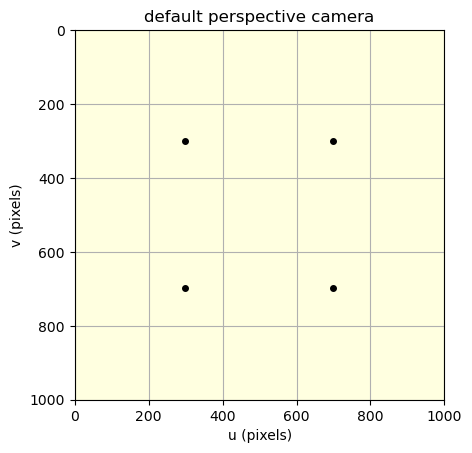

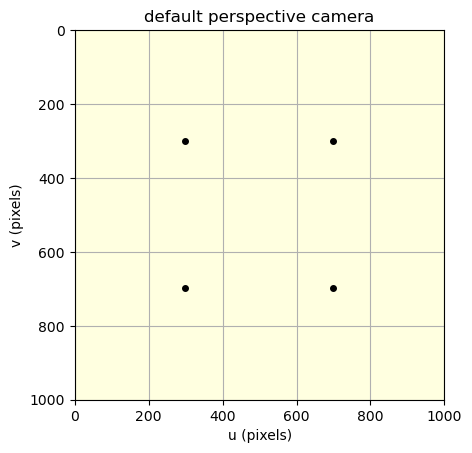

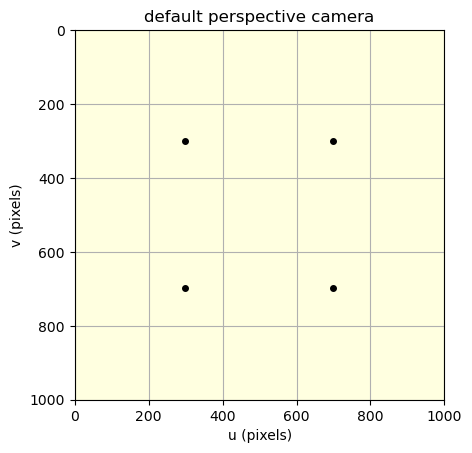

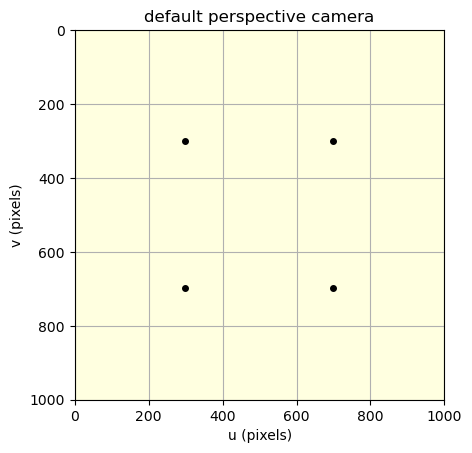

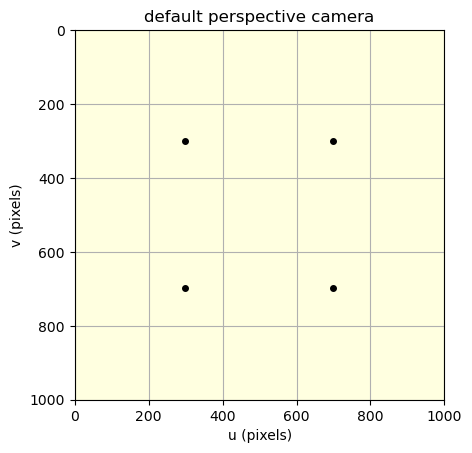

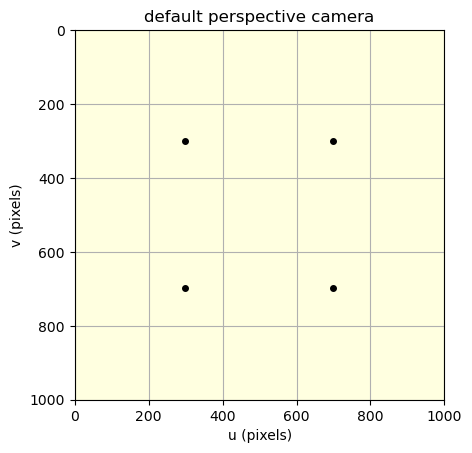

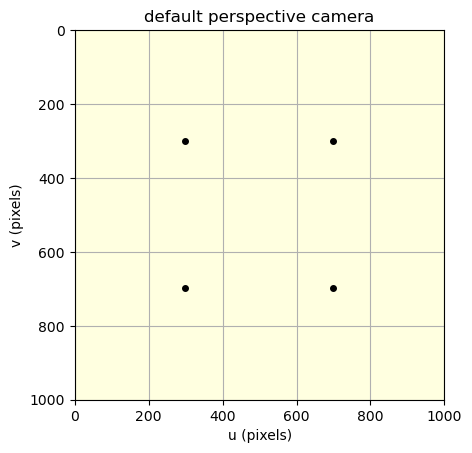

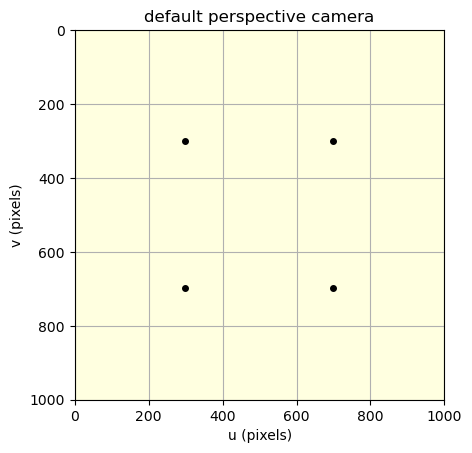

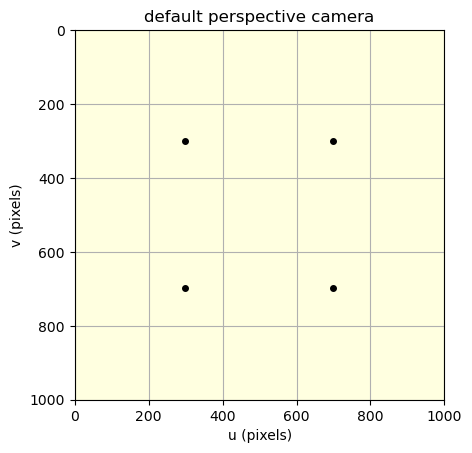

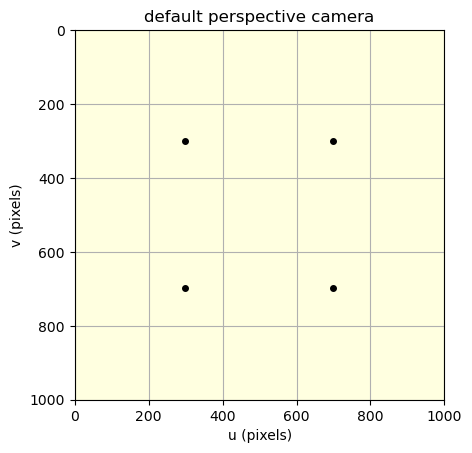

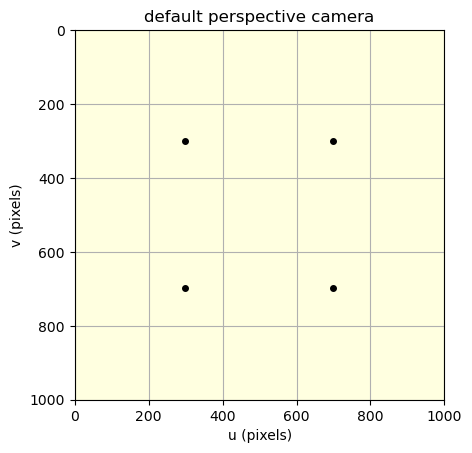

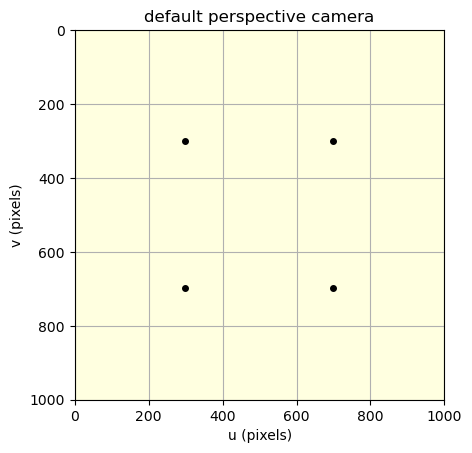

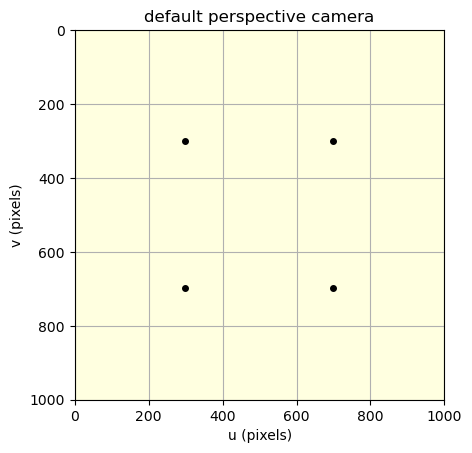

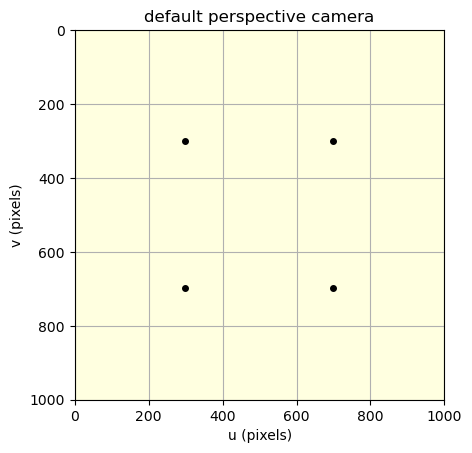

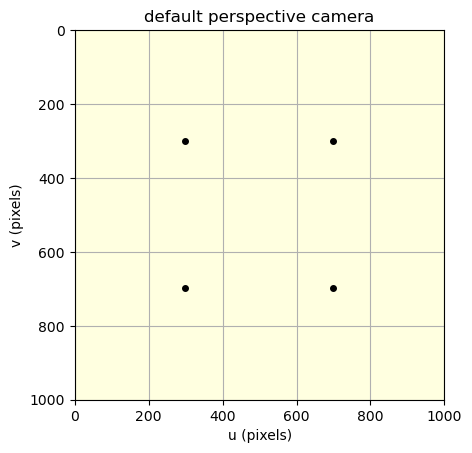

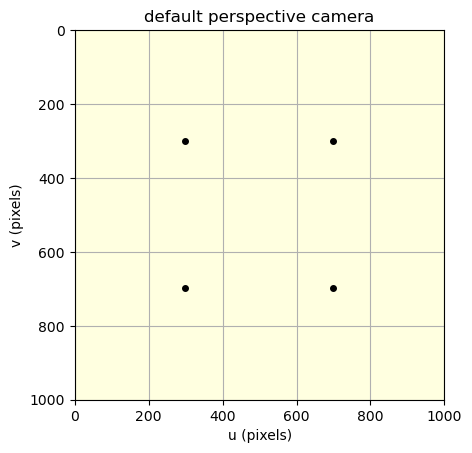

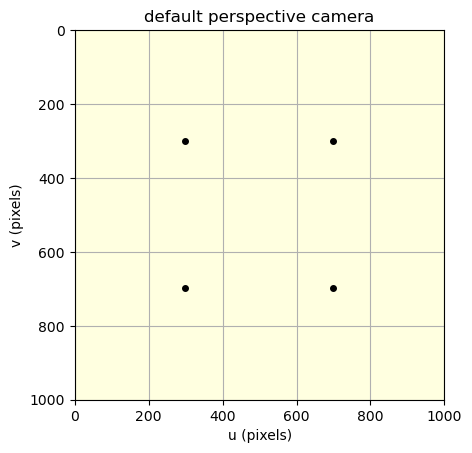

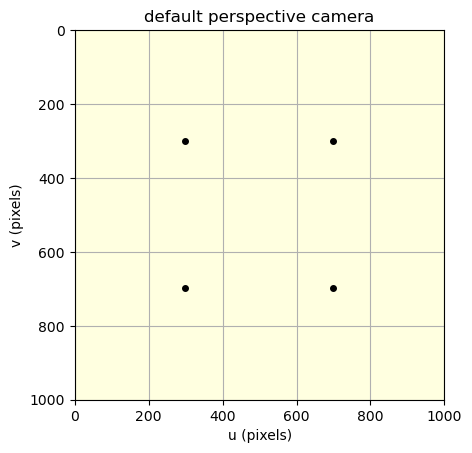

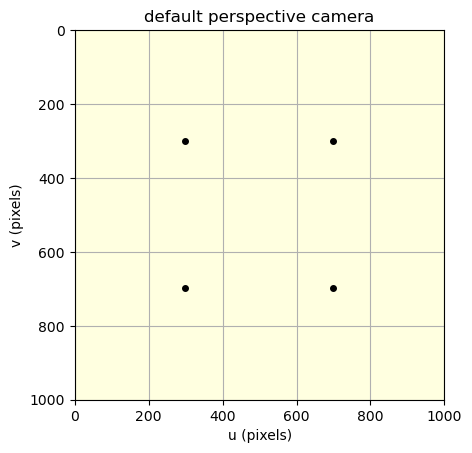

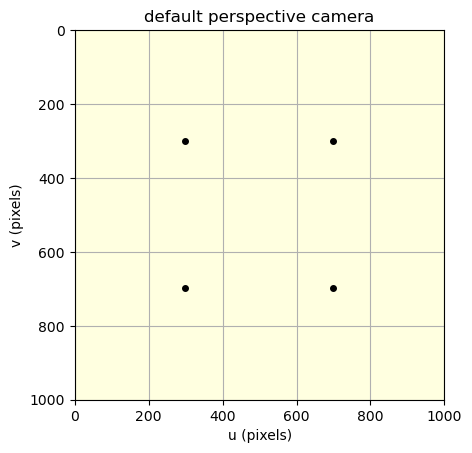

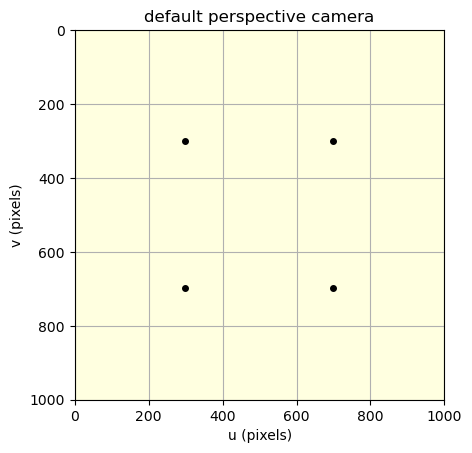

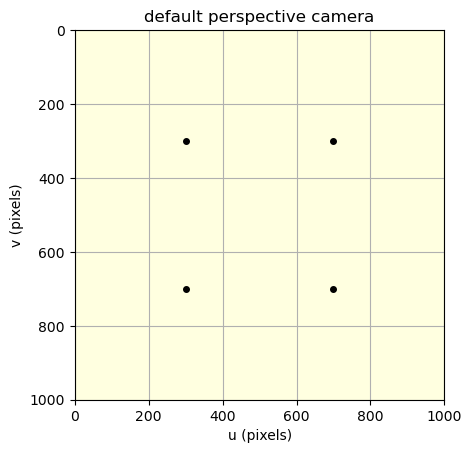

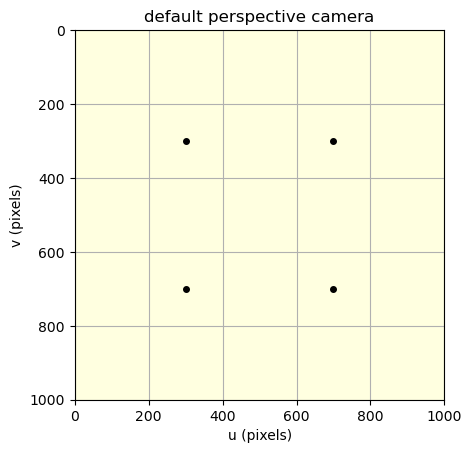

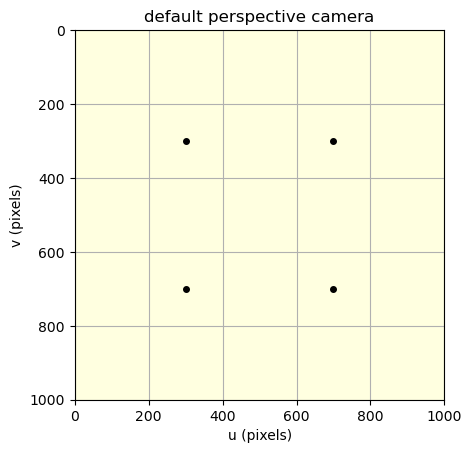

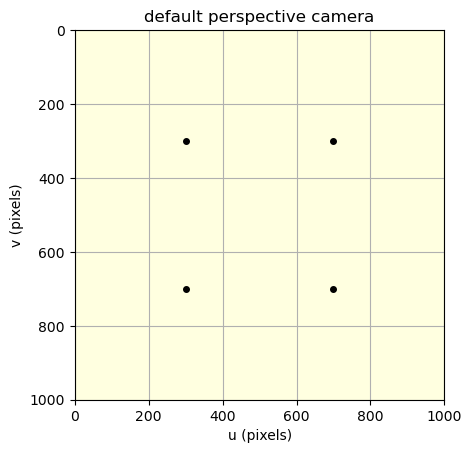

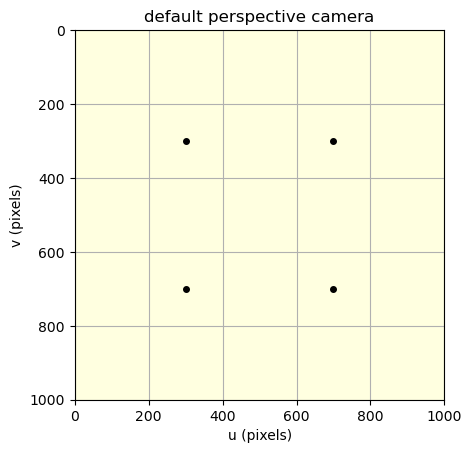

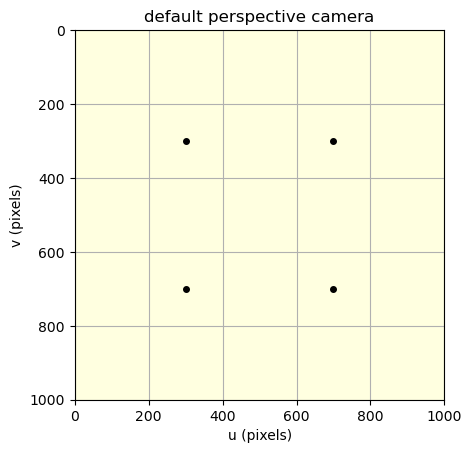

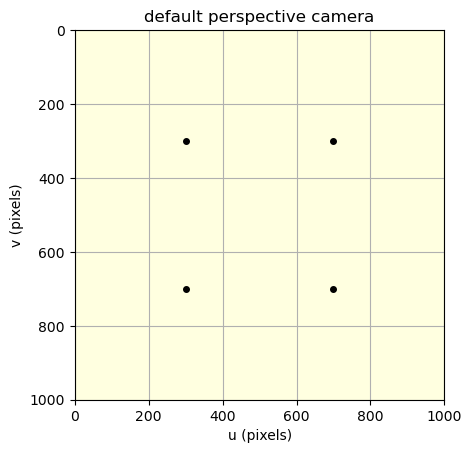

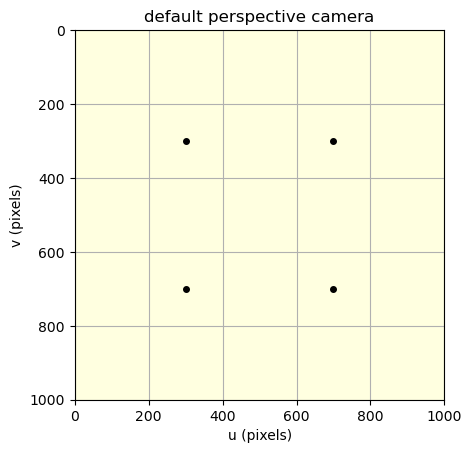

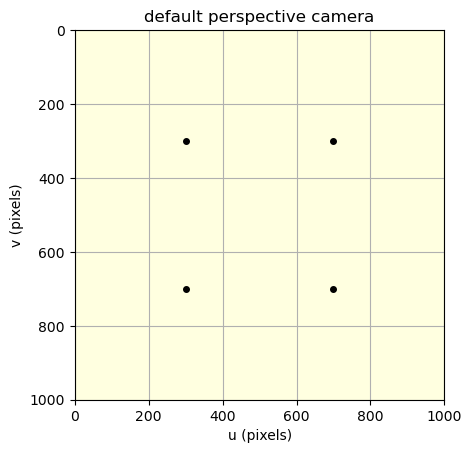

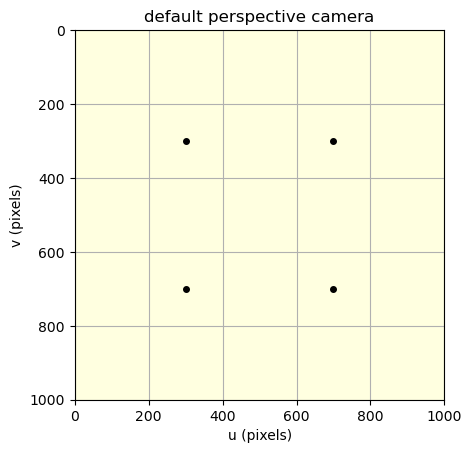

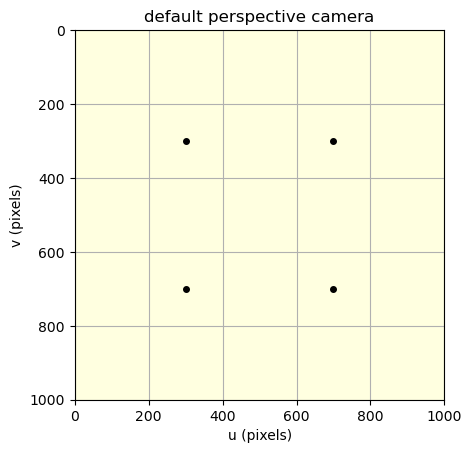

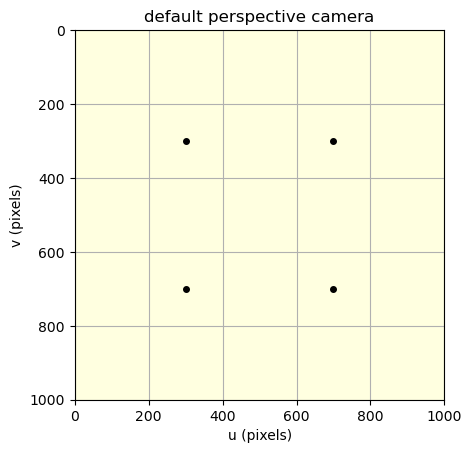

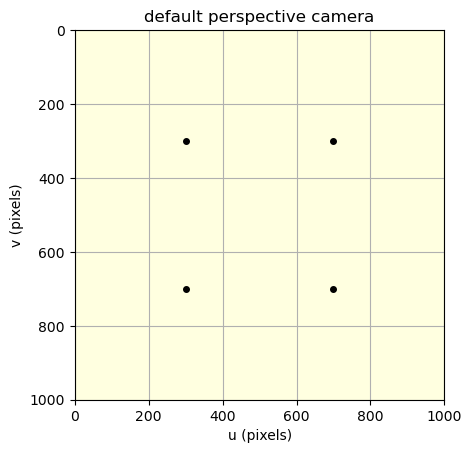

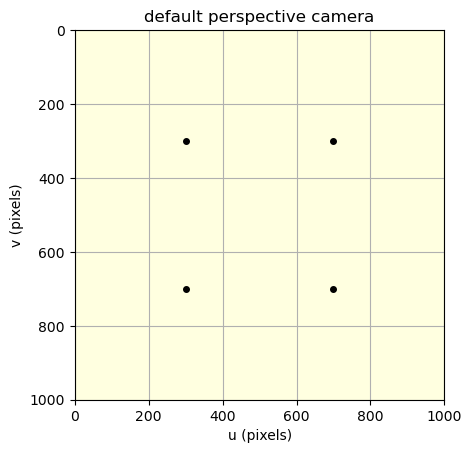

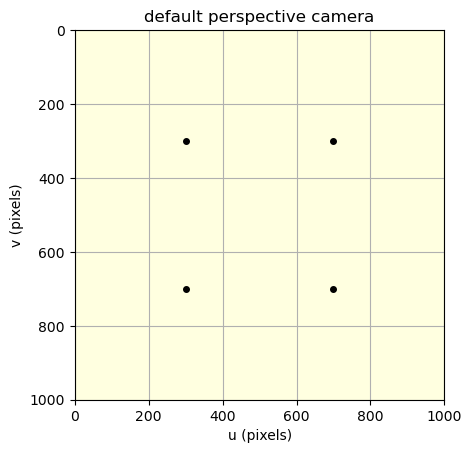

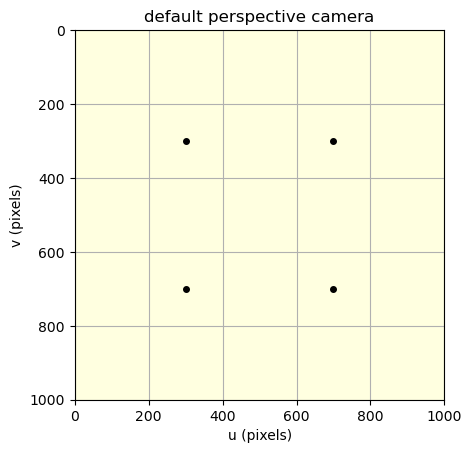

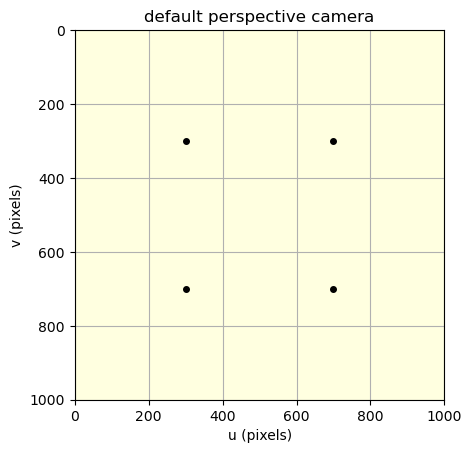

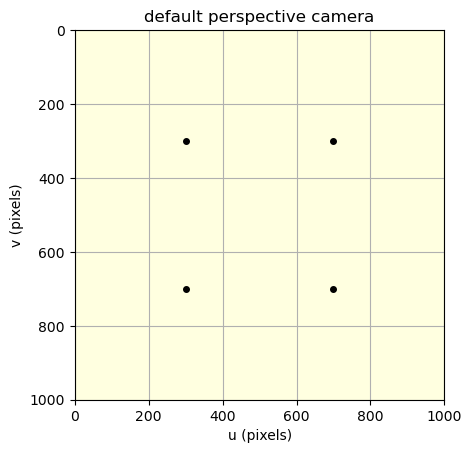

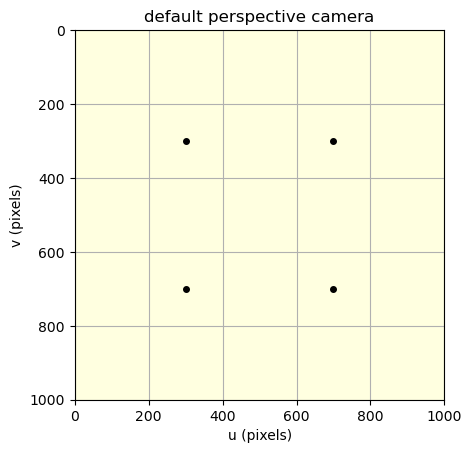

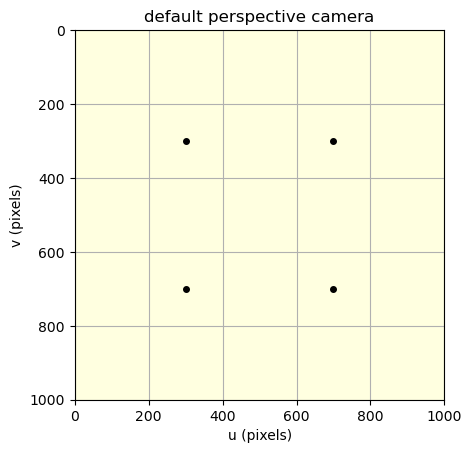

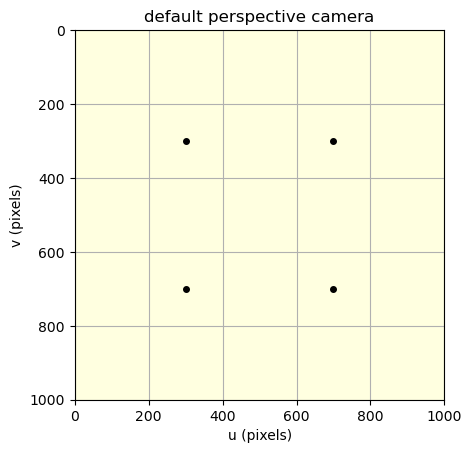

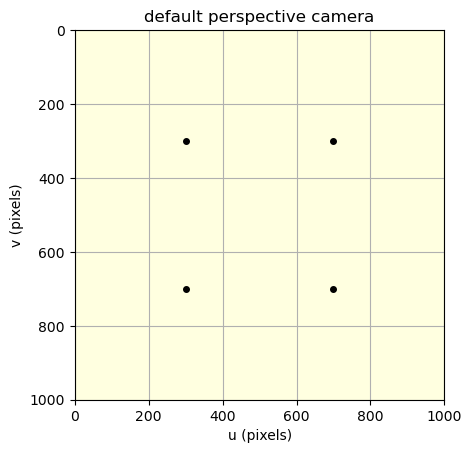

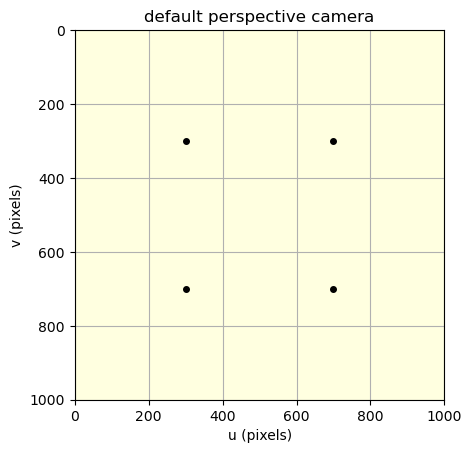

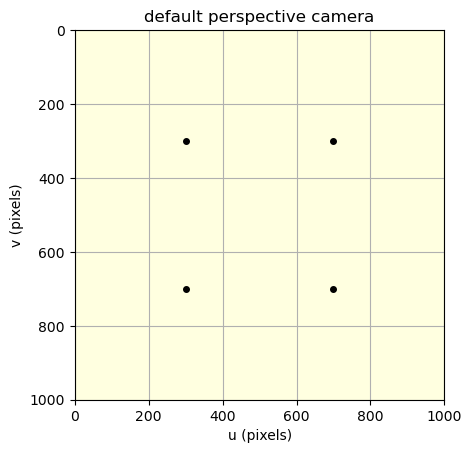

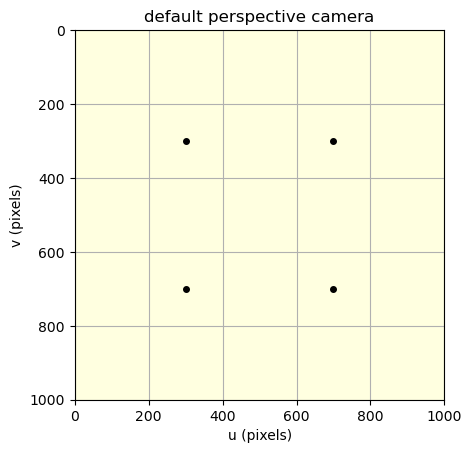

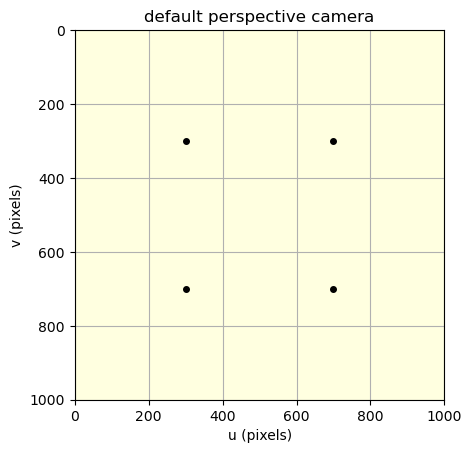

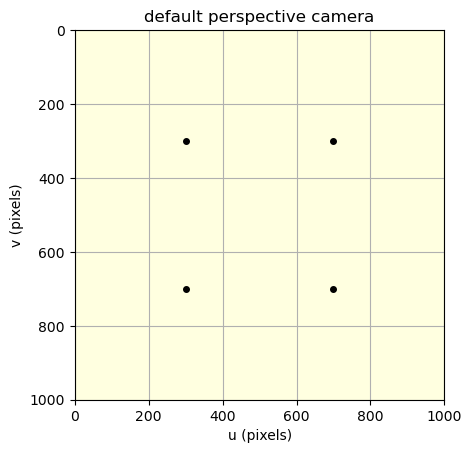

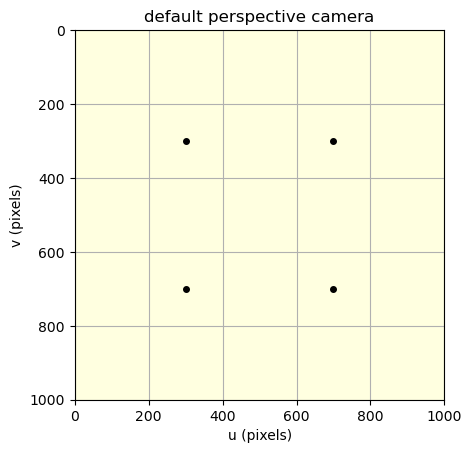

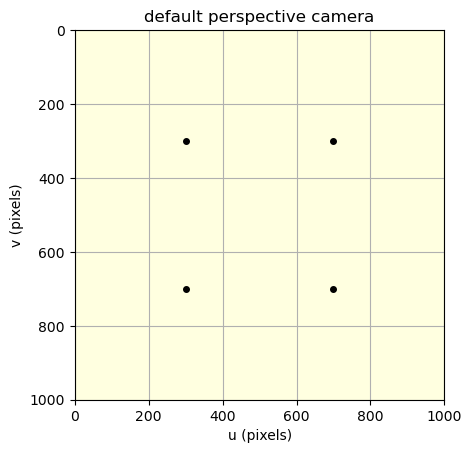

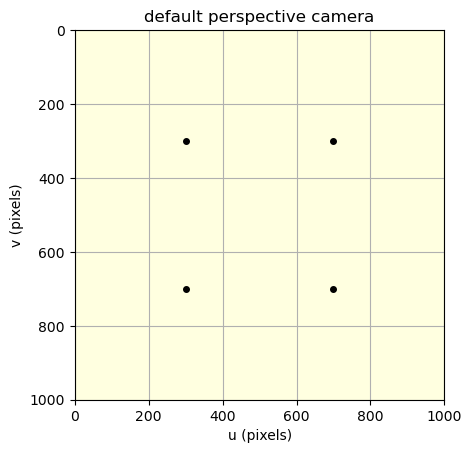

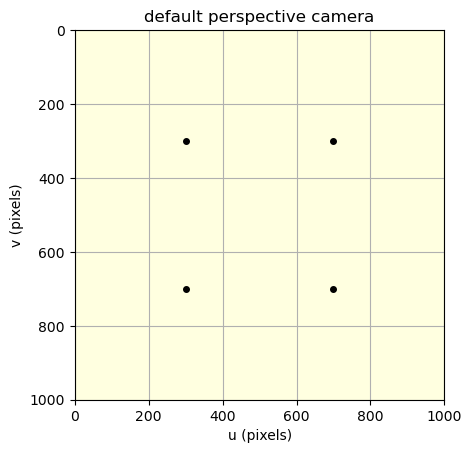

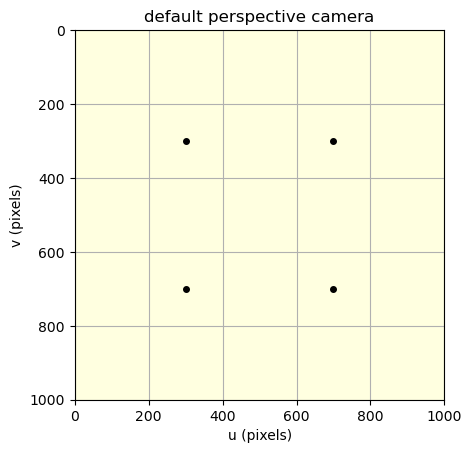

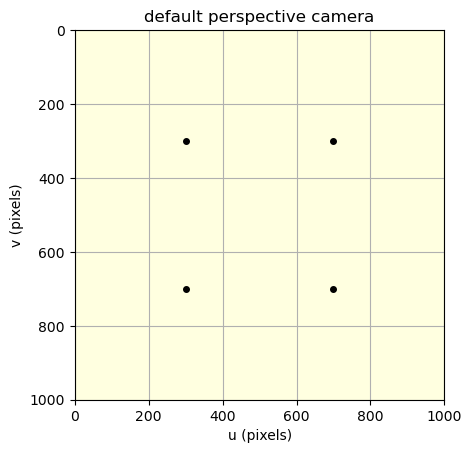

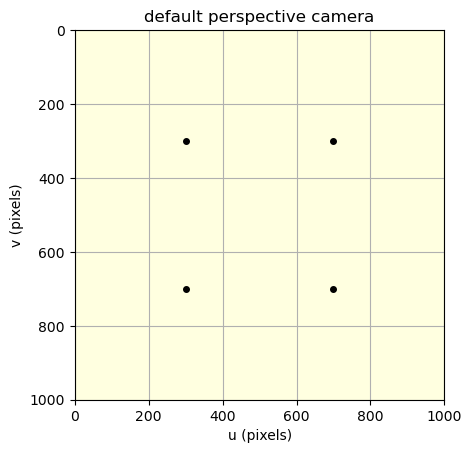

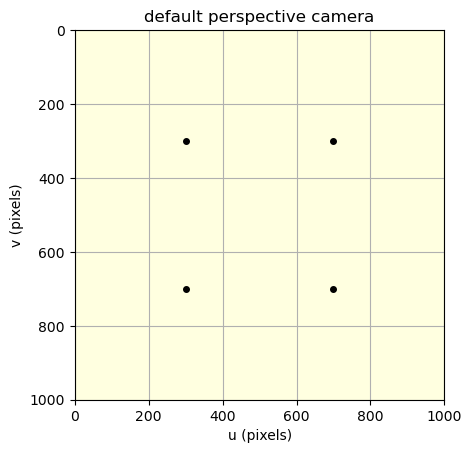

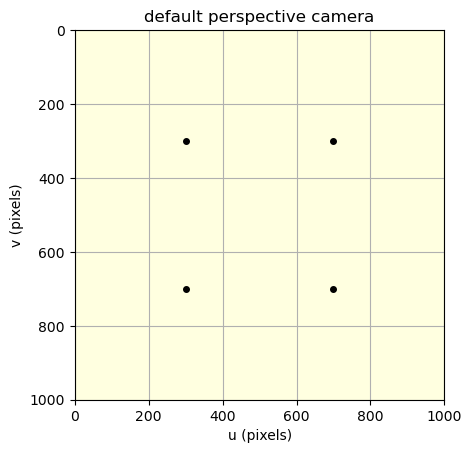

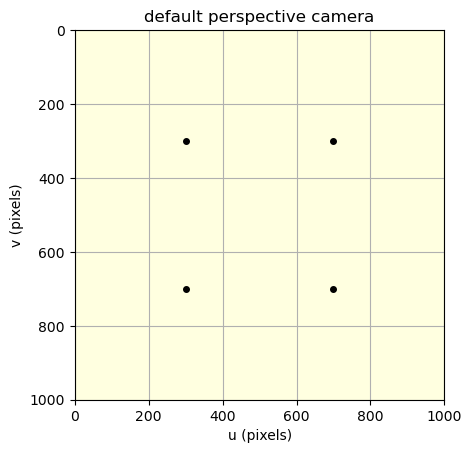

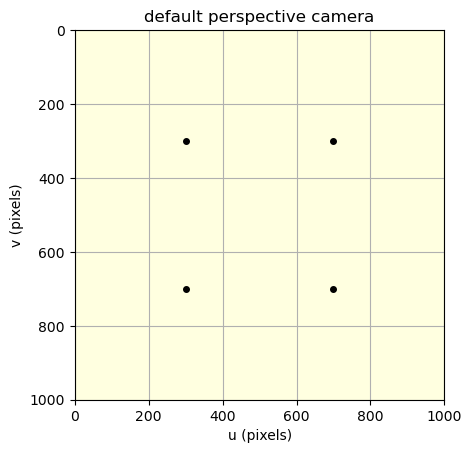

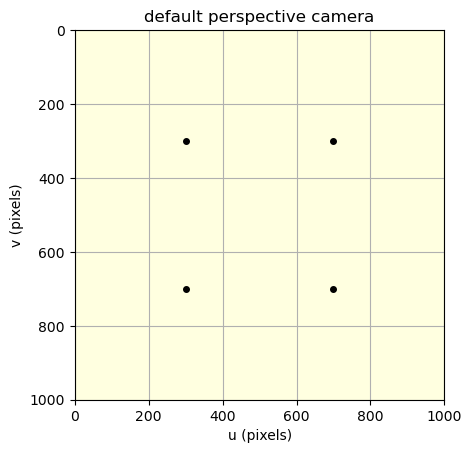

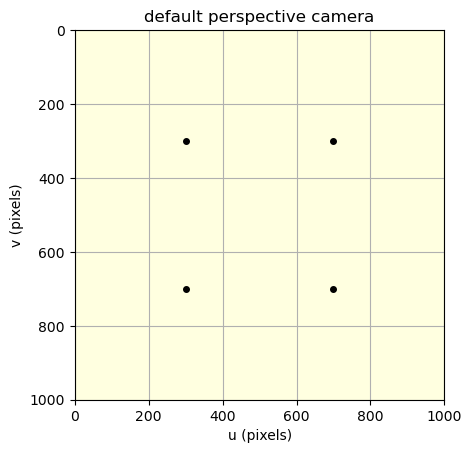

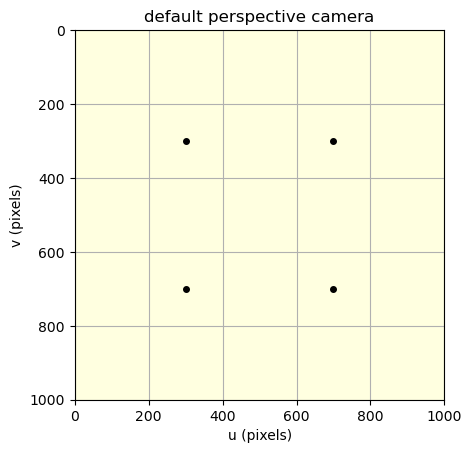

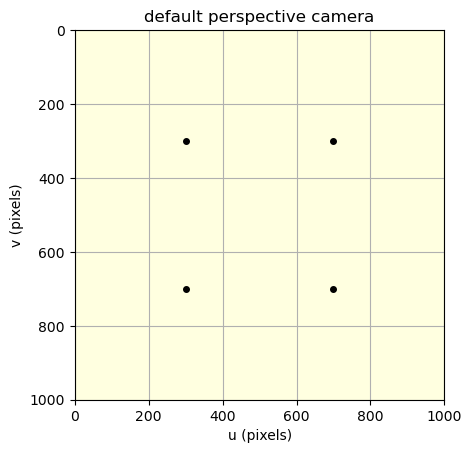

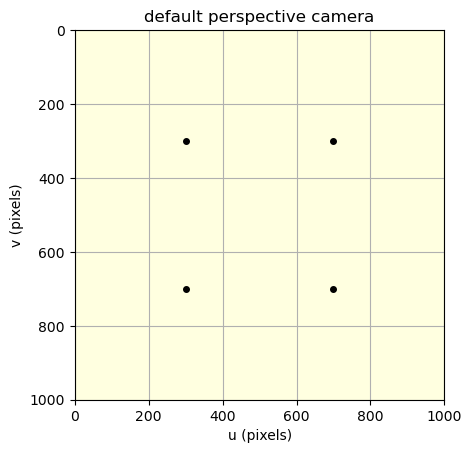

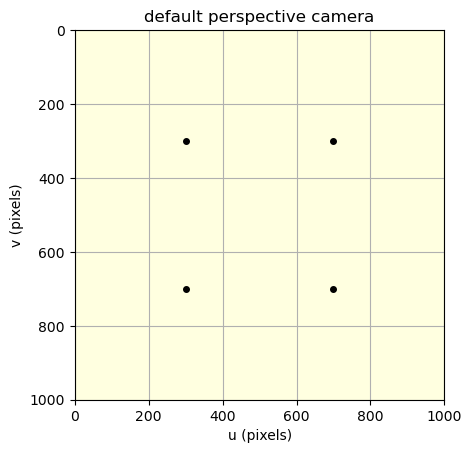

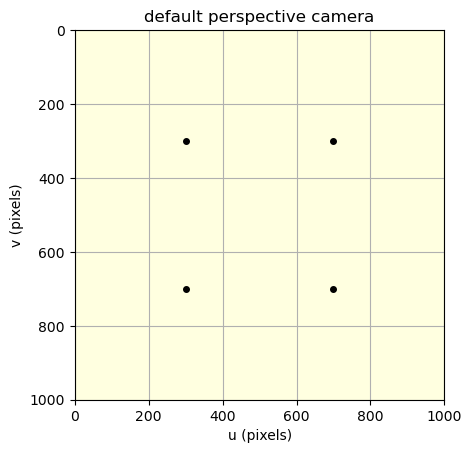

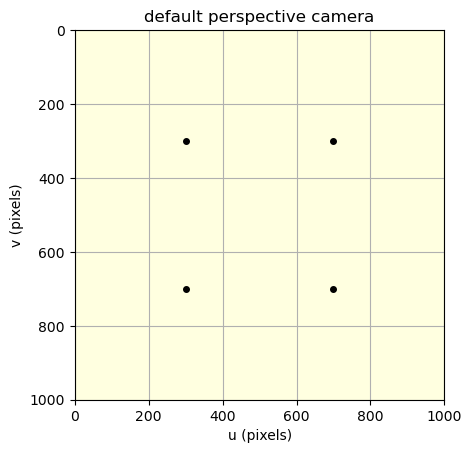

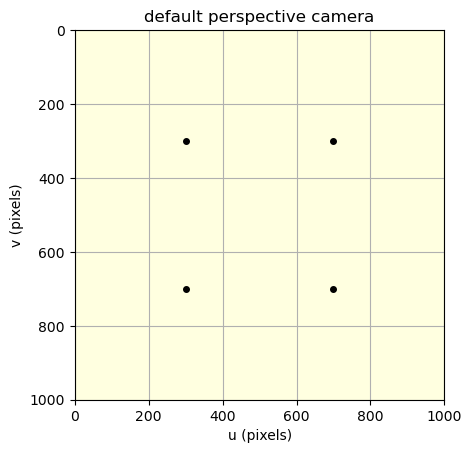

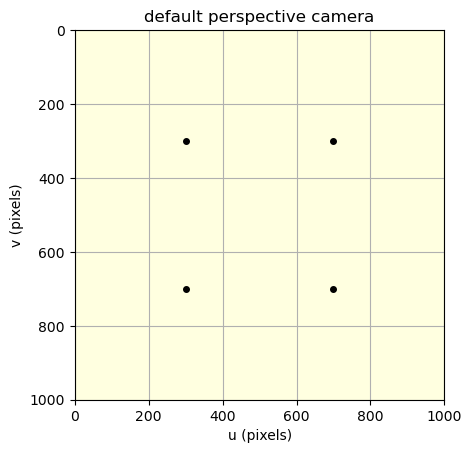

completed on iteration count


In [14]:
pbvs.run(200);

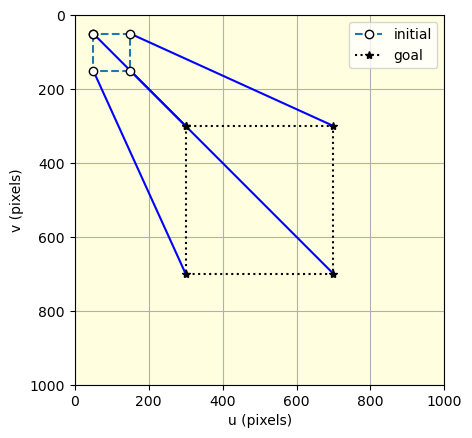

In [15]:
pbvs.plot_p();     # plot image plane trajectory

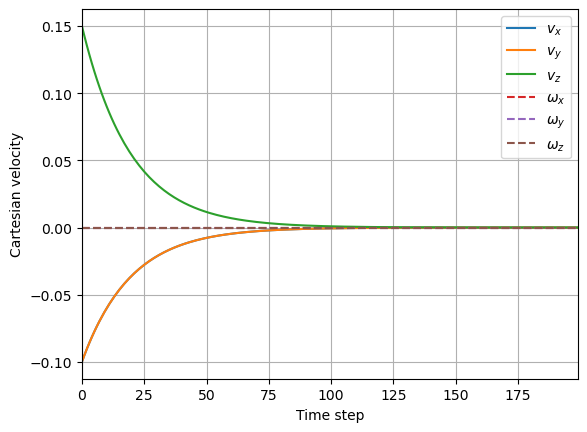

In [16]:
pbvs.plot_vel();   # plot camera velocity

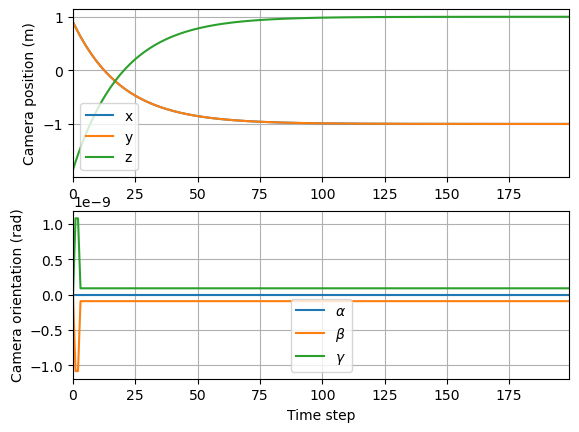

In [17]:
pbvs.plot_pose();  # plot camera trajectory

# 15.2 Image-Based Visual Servoing


## 15.2.1 Camera and Image Motion


In [18]:
camera = CentralCamera.Default();

In [19]:
P = [1, 1, 5];

In [20]:
p0 = camera.project_point(P)

In [21]:
p_dx = camera.project_point(P, pose=SE3.Tx(0.1))

In [22]:
(p_dx - p0) / 0.1

array([[    -160],
       [       0]])

In [23]:
(camera.project_point(P, pose=SE3.Tz(0.1) ) - p0) / 0.1

array([[   32.65],
       [   32.65]])

In [24]:
(camera.project_point(P, pose=SE3.Rx(0.1)) - p0) / 0.1

array([[   40.96],
       [   851.9]])

In [25]:
J = camera.visjac_p(p0, depth=5)

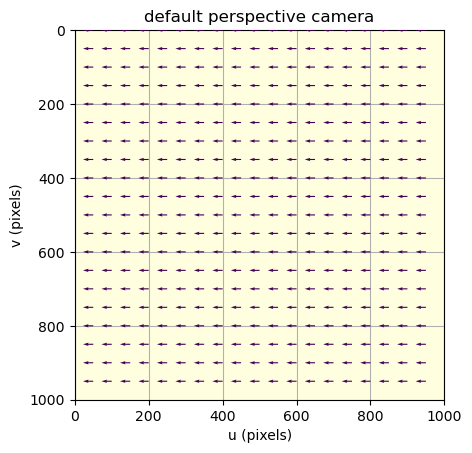

In [26]:
camera.flowfield([1, 0, 0, 0, 0, 0]);

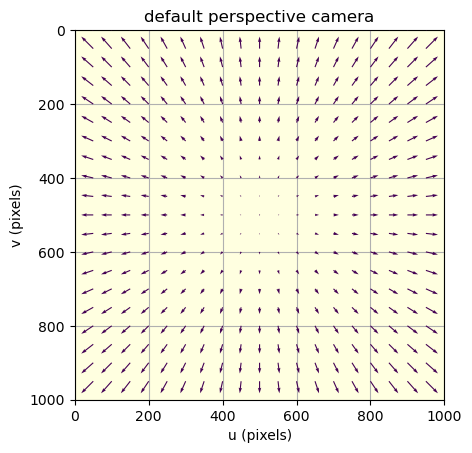

In [27]:
camera.flowfield([0, 0, 1, 0, 0, 0]);

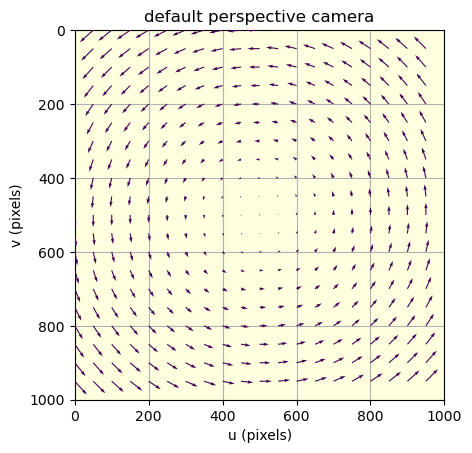

In [28]:
camera.flowfield([0, 0, 0, 0, 0, 1]);

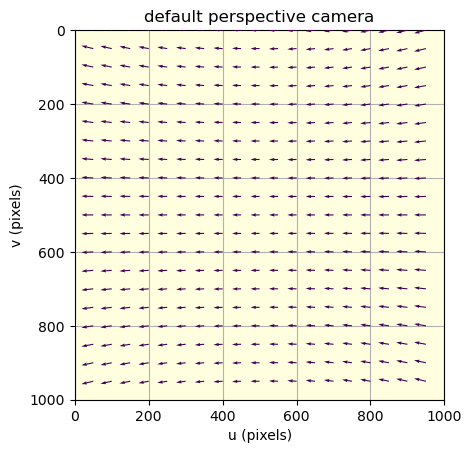

In [29]:
camera.flowfield([0, 0, 0, 0, 1, 0]);

In [30]:
camera.visjac_p(camera.pp, depth=1)

array([[    -800,        0,        0,        0,     -800,        0],
       [       0,     -800,        0,      800,        0,        0]])

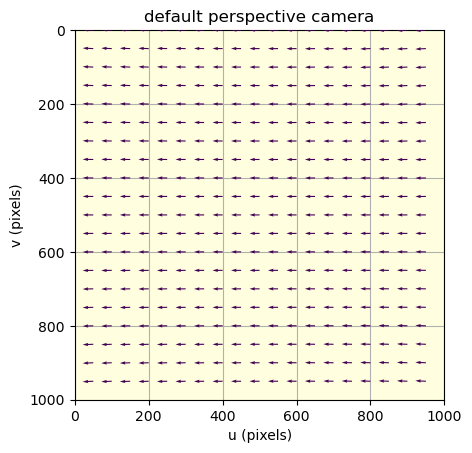

In [31]:
camera.f = 20e-3;
camera.flowfield([0, 0, 0, 0, 1, 0]);

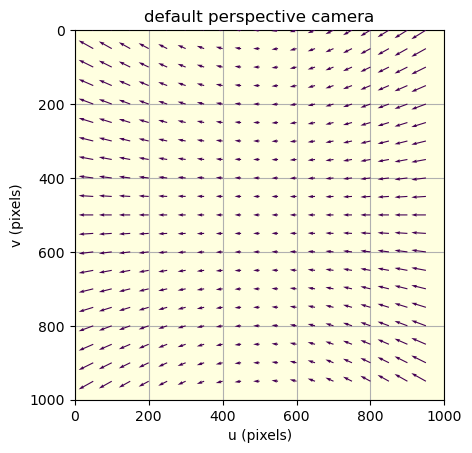

In [32]:
camera.f = 4e-3;
camera.flowfield([0, 0, 0, 0, 1, 0]);

In [33]:
J = camera.visjac_p(camera.pp, depth=1);

In [34]:
linalg.null_space(J)

array([[       0,        0,  -0.7071,        0],
       [       0,   0.7071,        0,        0],
       [       1,        0,        0,        0],
       [       0,   0.7071,        0,        0],
       [       0,        0,   0.7071,        0],
       [       0,        0,        0,        1]])

## 15.2.2 Controlling Feature Motion


In [35]:
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -2));

In [36]:
P = mkgrid(2, side=0.5, pose=SE3.Tz(3));

In [37]:
pd = 200 * np.array([[-1, -1, 1, 1], [-1, 1, 1, -1]]) + np.c_[camera.pp]

In [38]:
p = camera.project_point(P)

In [39]:
e = pd - p

In [40]:
J = camera.visjac_p(p, depth=1);

In [41]:
lmbda = 0.1;
v = lmbda * np.linalg.pinv(J) @ e.flatten(order="F")

In [42]:
camera.pose = camera.pose @ SE3.Delta(v);

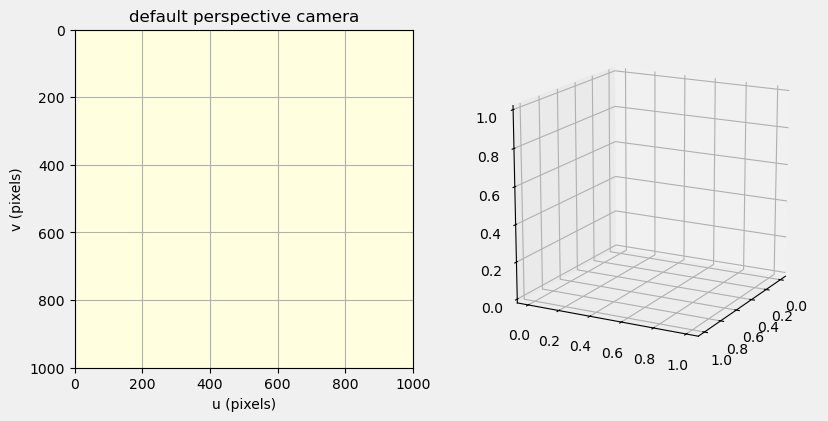

In [43]:
camera = CentralCamera.Default(pose=SE3.Trans(1, 1, -3) * SE3.Rz(0.6));
ibvs = IBVS(camera, P=P, p_d=pd);

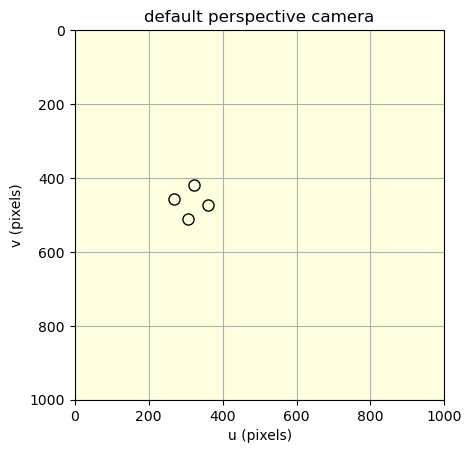

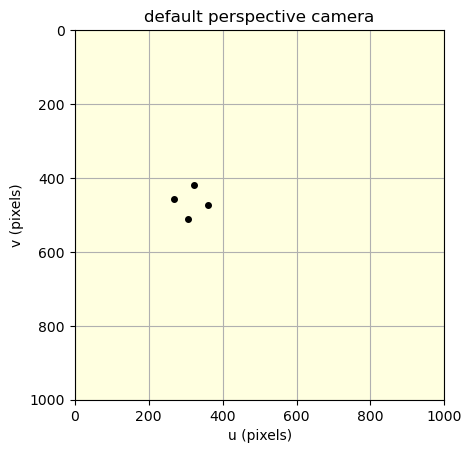

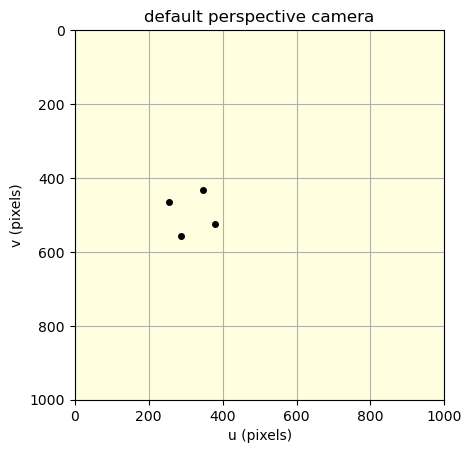

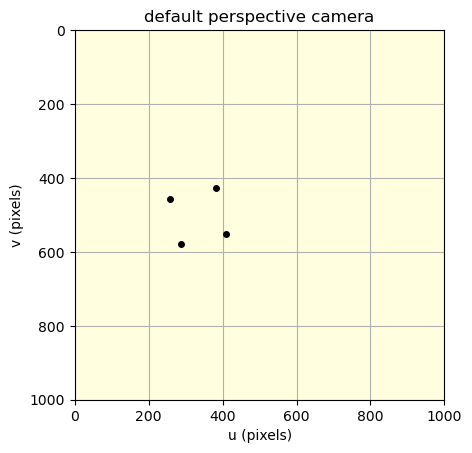

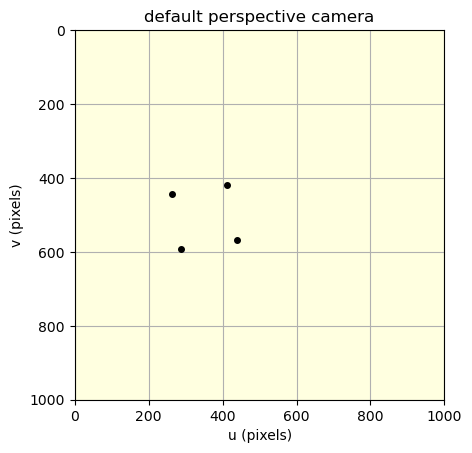

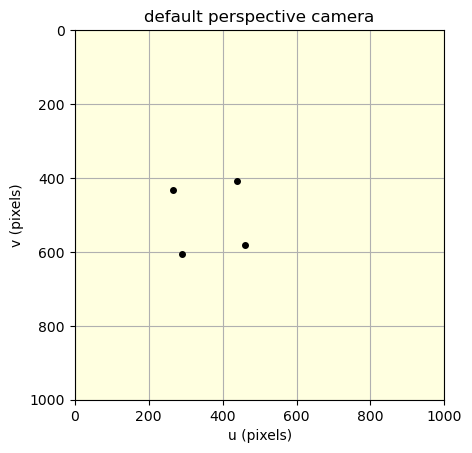

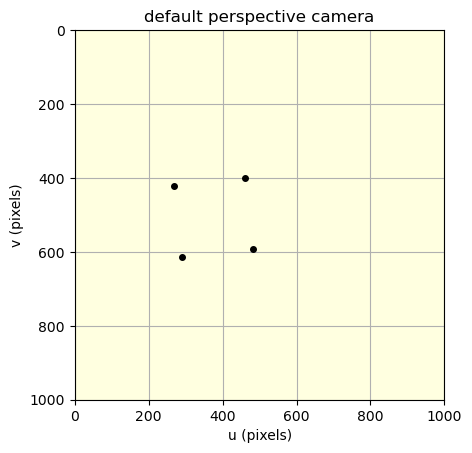

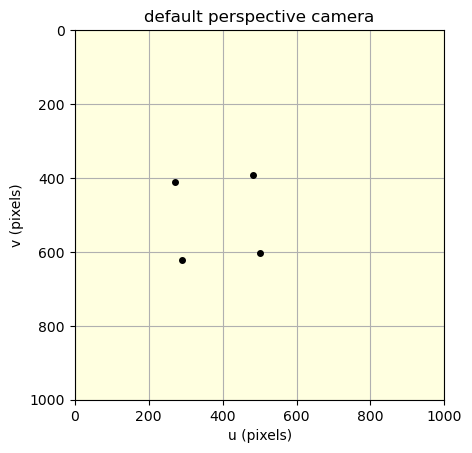

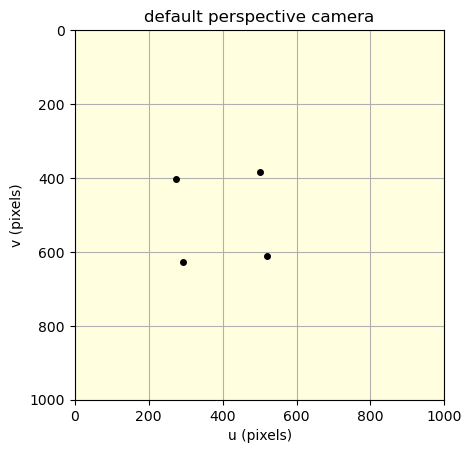

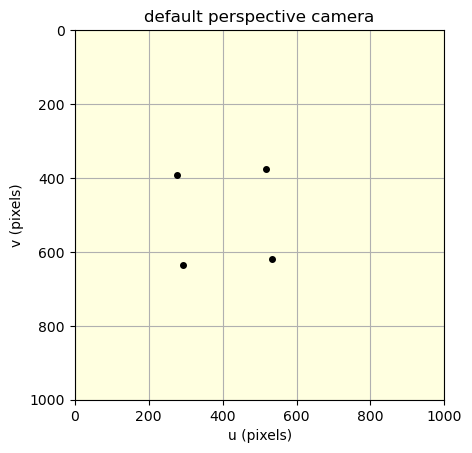

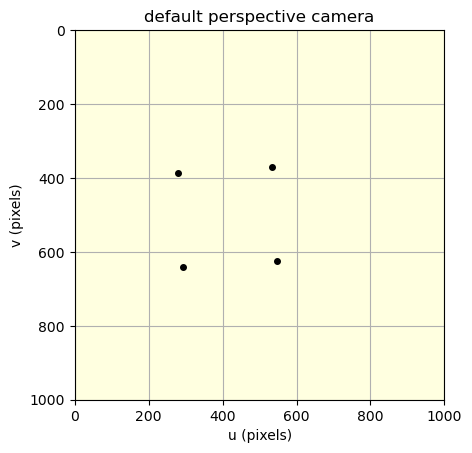

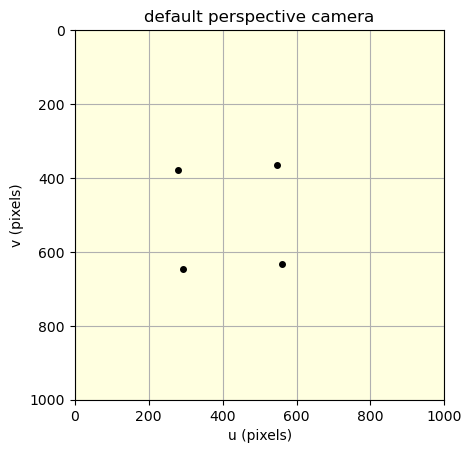

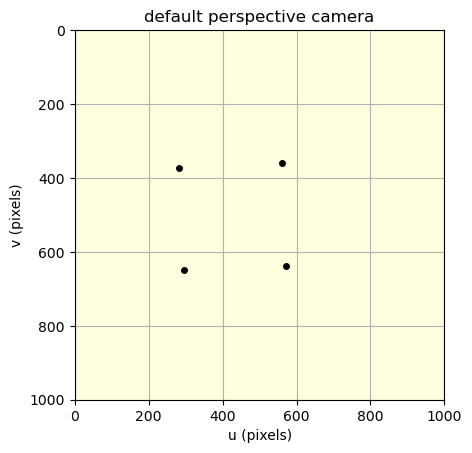

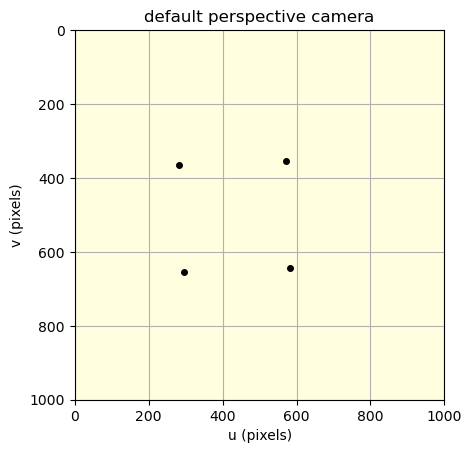

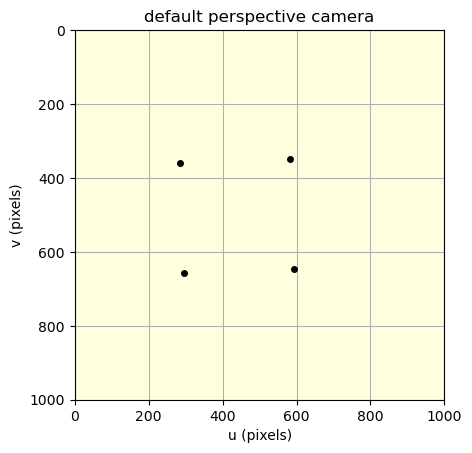

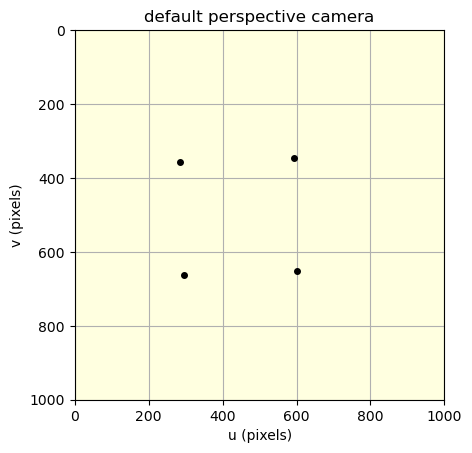

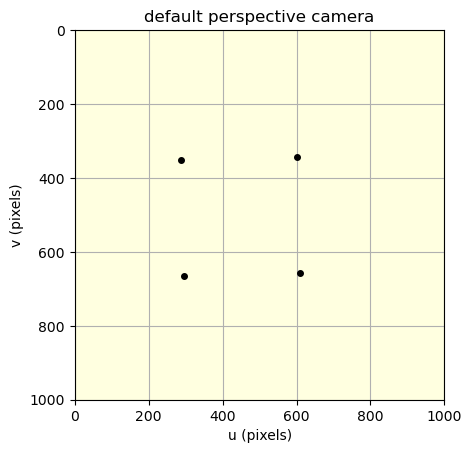

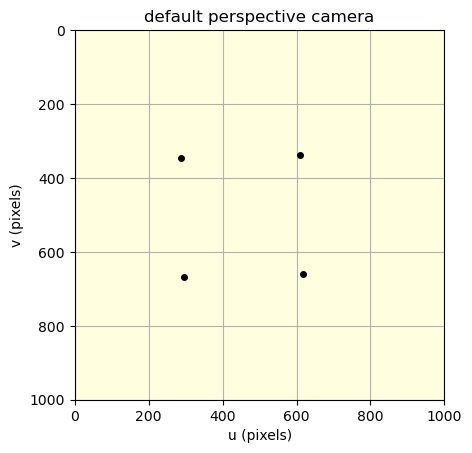

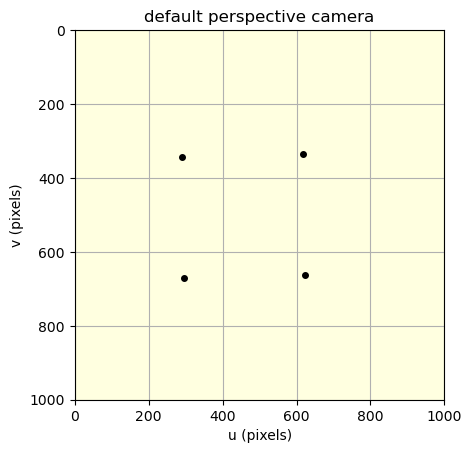

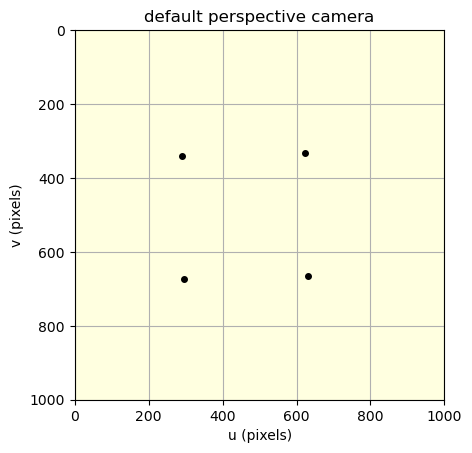

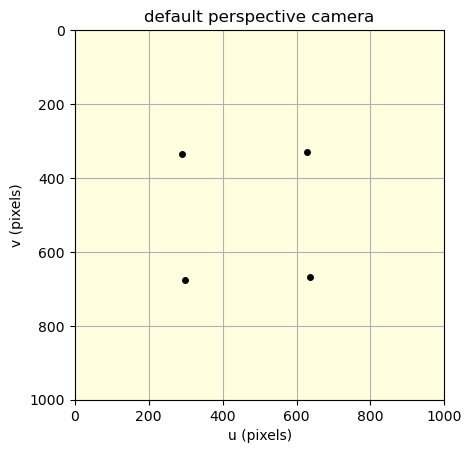

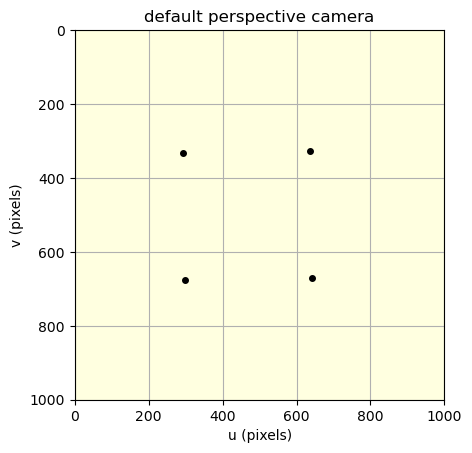

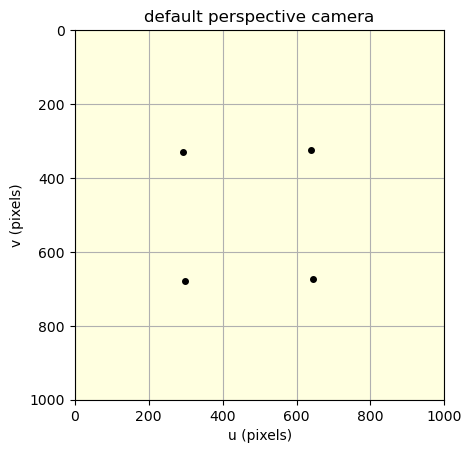

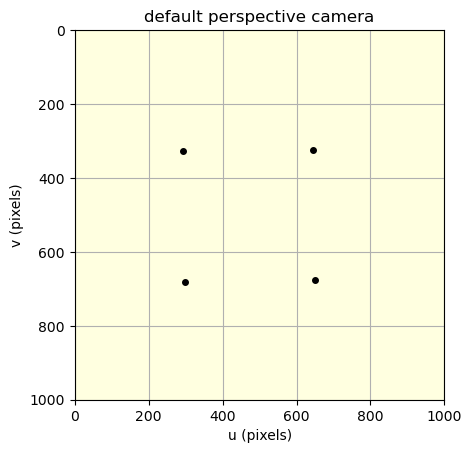

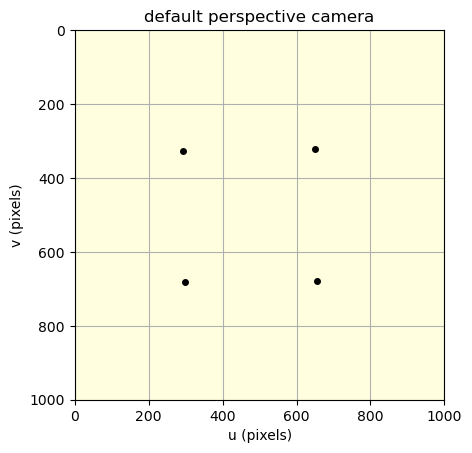

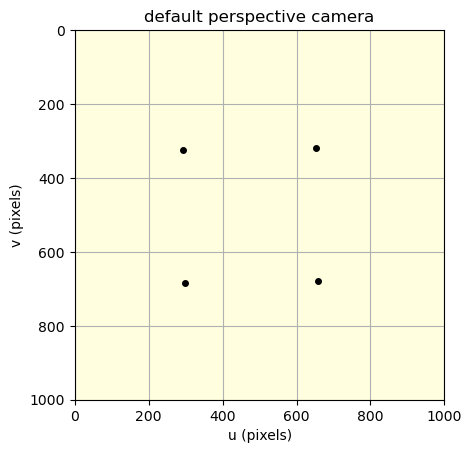

completed on iteration count


In [44]:
ibvs.run(25);

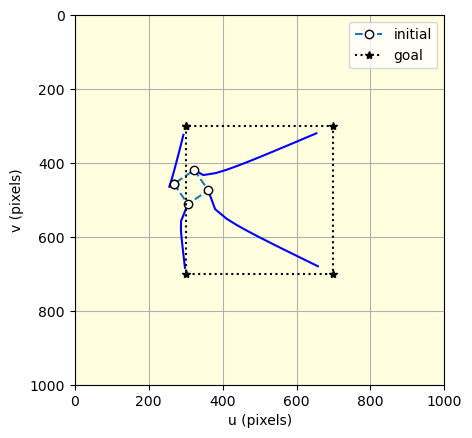

In [45]:
ibvs.plot_p();     # plot image plane trajectory

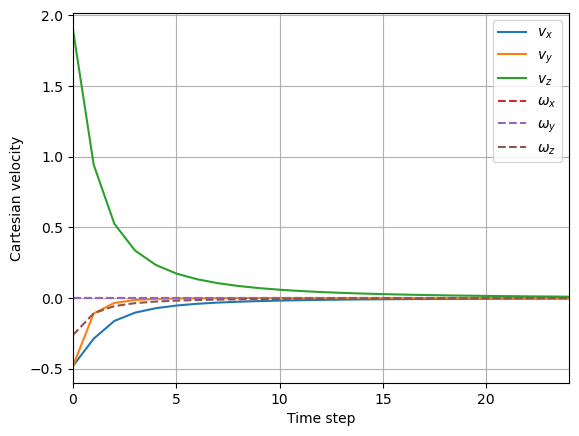

In [46]:
ibvs.plot_vel(); 

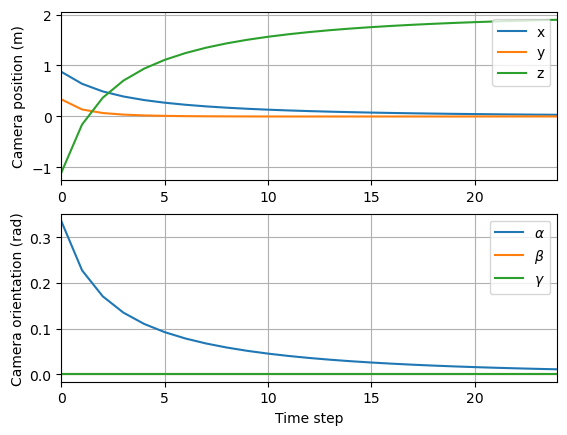

In [47]:
ibvs.plot_pose(); 

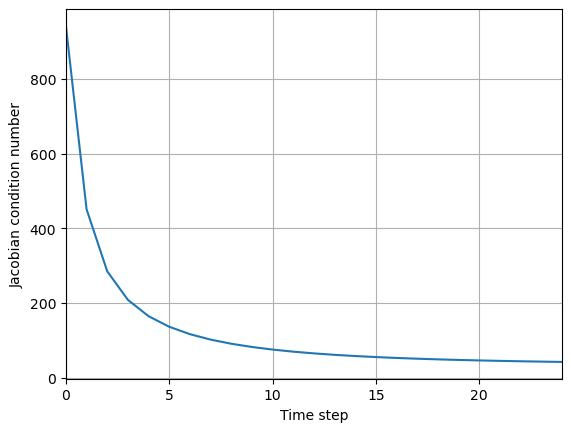

In [48]:
ibvs.plot_jcond();

In [49]:
%run -m IBVS-main -H

AttributeError: 'NoneType' object has no attribute 'origin'

In [ ]:
out

In [ ]:
plt.plot(out.t, out.y2)

In [ ]:
plt.plot(out.clock0.t, out.clock0.x)

## 15.2.3 Estimating Feature Depth


In [ ]:
ibvs = IBVS(camera, P=P, p_d=pd, depth=1);
ibvs.run(50)
ibvs = IBVS(camera, P=P, p_d=pd, depth=10);
ibvs.run(50)

In [ ]:
ibvs = IBVS(camera, P=P, p_d=pd, depthest=True);
ibvs.run()

## 15.2.4 Performance Issues


In [ ]:
pbvs.pose_0 = SE3.Trans(-2.1, 0, -3) * SE3.Rz(5*pi/4);
pbvs.run()

In [ ]:
ibvs.pose_0 = pbvs.pose_0;
ibvs.run()
ibvs.plot_p();

In [ ]:
ibvs.pose_0 = SE3.Tz(-1) * SE3.Rz(2);
ibvs.run(50)

In [ ]:
ibvs.pose_0 = SE3.Tz(-1) * SE3.Rz(pi);
ibvs.run(10)

# 15.3 Using Other Image Features


## 15.3.1 Line Features


In [ ]:
P = circle([0, 0, 3], 0.5, resolution=3);

In [ ]:
ibvs = IBVS_l.Example(camera);  # quick problem setup
ibvs.run()

## 15.3.2 Ellipse Features


In [ ]:
P = circle([0, 0, 3], 0.5, resolution=10);

In [ ]:
p = camera.project_point(P, pose=camera.pose, retinal=True);

In [ ]:
x, y = p
A = np.column_stack([y**2, -2*x*y, 2*x, 2*y, np.ones(x.shape)]);
b = -(x**2);
E, *_ = np.linalg.lstsq(A, b, rcond=None)

In [ ]:
plane = [0, 0, 1, -3];  # plane Z=3
J = camera.visjac_e(E, plane);
J.shape

In [ ]:
ibvs = IBVS_e.Example();  # quick problem setup
ibvs.run()

## 15.3.3 Photometric Features


# 15.4 Wrapping Up


## 15.4.1 Further Reading


## 15.4.2 Exercises
